# linear regreesion（线性回归）
注意：python版本为3.7

In [1]:
import pandas as pd
import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette="dark")
import matplotlib.pyplot as plt
import numpy as np
## import tensorflow as tf   代码是在1.0 基础上写的，目前是tf2.0，需要加入以下两句，使用1.0的API
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
df = pd.read_csv('ex1data1.txt', names=['population', 'profit'])#读取数据并赋予列名

In [3]:
#看前10行
df.head(3)

population   profit
0      6.1101  17.5920
1      5.5277   9.1302
2      8.5186  13.6620

In [4]:
## 数据的简要信息
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   population  97 non-null     float64
 1   profit      97 non-null     float64
dtypes: float64(2)
memory usage: 1.6 KB


In [5]:
##  数据的数值相关统计,计数，均值，标准差，分位数
df.describe()

population     profit
count   97.000000  97.000000
mean     8.159800   5.839135
std      3.869884   5.510262
min      5.026900  -2.680700
25%      5.707700   1.986900
50%      6.589400   4.562300
75%      8.578100   7.046700
max     22.203000  24.147000

***
# 看下原始数据

D:\Anaconda3\envs\tensorflow2-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Anaconda3\envs\tensorflow2-gpu\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


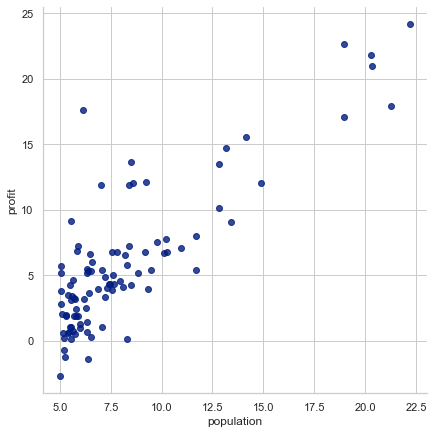

In [6]:
## 画图软件涉猎较少，标题，X,Y轴分别是什么数据要制定，图的大小尺寸要设置，外观的一些参数要设置
sns.lmplot('population', 'profit', df, size=6, fit_reg=False)
plt.show()

In [7]:
def get_X(df):#读取特征
#     """
#     use concat to add intersect feature to avoid side effect
#     not efficient for big dataset though
#     """
    ones = pd.DataFrame({'ones': np.ones(len(df))})#ones是m行1列的dataframe
    data = pd.concat([ones, df], axis=1)  # 合并数据，根据列合并
    return data.iloc[:, :-1].values  # 这个操作返回 ndarray,不是矩阵


def get_y(df):#读取标签
#     '''assume the last column is the target'''
    return np.array(df.iloc[:, -1])#df.iloc[:, -1]是指df的最后一列   


def normalize_feature(df):
    """
    Applies function along input axis(default 0) of DataFrame
    标准化方法有多种：
    归一化Max-Min
    实现中心化Z-Score
    用于稀疏数据的MaxAbs
    针对离群点的RobustScaler
    
    是否需要做归一化数据，要具体分析
    
    """
    return df.apply(lambda column: (column - column.mean()) / column.std())#特征缩放 z-score 标准化(zero-mean normalization)

多变量的假设 h 表示为：\\[{{h}_{\theta }}\left( x \right)={{\theta }_{0}}+{{\theta }_{1}}{{x}_{1}}+{{\theta }_{2}}{{x}_{2}}+...+{{\theta }_{n}}{{x}_{n}}\\] 
这个公式中有n+1个参数和n个变量，为了使得公式能够简化一些，引入${{x}_{0}}=1$，则公式转化为：  
此时模型中的参数是一个n+1维的向量，任何一个训练实例也都是n+1维的向量，特征矩阵X的维度是 m*(n+1)。 因此公式可以简化为：${{h}_{\theta }}\left( x \right)={{\theta }^{T}}X$，其中上标T代表矩阵转置。


In [8]:
def linear_regression(X_data, y_data, alpha, epoch, optimizer=tf.train.GradientDescentOptimizer):
      # placeholder for graph input
    X = tf.placeholder(tf.float32, shape=X_data.shape)
    y = tf.placeholder(tf.float32, shape=y_data.shape)

    # construct the graph
    with tf.variable_scope('linear-regression'):
        W = tf.get_variable("weights",
                            (X_data.shape[1], 1),
                            initializer=tf.constant_initializer())  # n*1

        y_pred = tf.matmul(X, W)  # m*n @ n*1 -> m*1

        loss = 1 / (2 * len(X_data)) * tf.matmul((y_pred - y), (y_pred - y), transpose_a=True)  # (m*1).T @ m*1 = 1*1

    opt = optimizer(learning_rate=alpha)
    opt_operation = opt.minimize(loss)

    # run the session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        loss_data = []

        for i in range(epoch):
            _, loss_val, W_val = sess.run([opt_operation, loss, W], feed_dict={X: X_data, y: y_data})
            loss_data.append(loss_val[0, 0])  # because every loss_val is 1*1 ndarray

            if len(loss_data) > 1 and np.abs(loss_data[-1] - loss_data[-2]) < 10 ** -9:  # early break when it's converged
                # print('Converged at epoch {}'.format(i))
                break

    # clear the graph
    tf.reset_default_graph()
    return {'loss': loss_data, 'parameters': W_val}  # just want to return in row vector format

In [9]:

history  = linear_regression(get_X(df),get_y(df),0.001,5000)


D:\Anaconda3\envs\tensorflow2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in float_scalars
D:\Anaconda3\envs\tensorflow2-gpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less


# 计算代价函数
$$J\left( \theta  \right)=\frac{1}{2m}\sum\limits_{i=1}^{m}{{{\left( {{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}} \right)}^{2}}}$$
其中：\\[{{h}_{\theta }}\left( x \right)={{\theta }^{T}}X={{\theta }_{0}}{{x}_{0}}+{{\theta }_{1}}{{x}_{1}}+{{\theta }_{2}}{{x}_{2}}+...+{{\theta }_{n}}{{x}_{n}}\\] 

In [10]:
X = get_X(df)
print(X.shape, type(X))

y = get_y(df)
print(y.shape, type(y))
#看下数据维度

(97, 2) <class 'numpy.ndarray'>
(97,) <class 'numpy.ndarray'>


In [11]:
theta = np.zeros(X.shape[1])#X.shape[1]=2,代表特征数n
theta

array([0., 0.])

In [12]:
def lr_cost(theta, X, y):
#     """
#     X: R(97*2),
#     y: R(97*1)
#     theta : R(2*1), 线性回归的参数矩阵
#     """
    m = X.shape[0]#m为样本数
    inner = X.dot(theta) - y  # X @ theta等价于X.dot(theta) 97*2 dot 2*1 得到 97*1   
    # 利用向量点乘求每个元素平方后的和
    square_sum = inner.T.dot(inner) ## 1*97 dot 97*1 得到 1*1  
    cost = square_sum / (2 * m)

    return cost

In [13]:
lr_cost(theta, X, y)#返回theta的值

32.07273387745567

# batch gradient decent（批量梯度下降）
$${{\theta }_{j}}:={{\theta }_{j}}-\alpha \frac{\partial }{\partial {{\theta }_{j}}}J\left( \theta  \right)$$

In [14]:
def gradient(theta, X, y):
    m = X.shape[0]
    inner = X.T @ (X @ theta - y)  # (m,n).T @ (m, 1) -> (n, 1)，X @ theta等价于X.dot(theta)     梯度计算公式
    return inner / m

In [15]:
def batch_gradient_decent(theta, X, y, epoch, alpha=0.01):
#   拟合线性回归，返回参数和代价
#     epoch: 批处理的轮数
#     """
    cost_data = [lr_cost(theta, X, y)]
    _theta = theta.copy()  # 拷贝一份，不和原来的theta混淆

    for _ in range(epoch):
        _theta = _theta - alpha * gradient(_theta, X, y)
        cost_data.append(lr_cost(_theta, X, y))
        
        print ("训练轮数: %d | 误差: %.20f | 参数矩阵: %s" % ( _,lr_cost(_theta, X, y),_theta))

    return _theta, cost_data
#批量梯度下降函数

In [16]:
epoch = 5000
final_theta, cost_data = batch_gradient_decent(theta, X, y, epoch)

训练轮数: 0 | 误差: 6.73719046487001094192 | 参数矩阵: [0.05839135 0.6532885 ]
训练轮数: 1 | 误差: 5.93159356860495634578 | 参数矩阵: [0.06289175 0.77000978]
训练轮数: 2 | 误差: 5.90115470708138811773 | 参数矩阵: [0.05782293 0.79134812]
训练轮数: 3 | 误差: 5.89522858644422065311 | 参数矩阵: [0.05106363 0.79572981]
训练轮数: 4 | 误差: 5.89009494311732950678 | 参数矩阵: [0.04401438 0.79709618]
训练轮数: 5 | 误差: 5.88500415844364610507 | 参数矩阵: [0.03692413 0.79792547]
训练轮数: 6 | 误差: 5.87993248049141836731 | 参数矩阵: [0.02983712 0.79865824]
训练轮数: 7 | 误差: 5.87487909476257286201 | 参数矩阵: [0.02276118 0.79937279]
训练轮数: 8 | 误差: 5.86984391180638631624 | 参数矩阵: [0.0156977  0.80008305]
训练轮数: 9 | 误差: 5.86482686531292873866 | 参数矩阵: [0.0086469 0.8007915]
训练轮数: 10 | 误差: 5.85982788993217873497 | 参数矩阵: [0.00160879 0.80149857]
训练轮数: 11 | 误差: 5.85484692057228972573 | 参数矩阵: [-0.00541662  0.80220436]
训练轮数: 12 | 误差: 5.84988389237658701347 | 参数矩阵: [-0.01242938  0.80290886]
训练轮数: 13 | 误差: 5.84493874072203389858 | 参数矩阵: [-0.01942949  0.8036121 ]
训练轮数: 14 | 误差: 5.840011401

训练轮数: 555 | 误差: 4.67047652141058655673 | 参数矩阵: [-2.43786815  1.0465705 ]
训练轮数: 556 | 误差: 4.66977952704373322490 | 参数矩阵: [-2.44049617  1.04683451]
训练轮数: 557 | 误差: 4.66908504321036588181 | 参数矩阵: [-2.44311946  1.04709805]
训练轮数: 558 | 误差: 4.66839306086768868198 | 参数矩阵: [-2.44573802  1.04736111]
训练轮数: 559 | 误差: 4.66770357100547617080 | 参数矩阵: [-2.44835187  1.0476237 ]
训练轮数: 560 | 误差: 4.66701656464595782126 | 参数矩阵: [-2.450961    1.04788582]
训练轮数: 561 | 误差: 4.66633203284369901809 | 参数矩阵: [-2.45356542  1.04814746]
训练轮数: 562 | 误差: 4.66564996668548825909 | 参数矩阵: [-2.45616515  1.04840863]
训练轮数: 563 | 误差: 4.66497035729021813921 | 参数矩阵: [-2.4587602   1.04866933]
训练轮数: 564 | 误差: 4.66429319580877077556 | 参数矩阵: [-2.46135057  1.04892956]
训练轮数: 565 | 误差: 4.66361847342390234417 | 参数矩阵: [-2.46393626  1.04918932]
训练轮数: 566 | 误差: 4.66294618135012406412 | 参数矩阵: [-2.4665173   1.04944861]
训练轮数: 567 | 误差: 4.66227631083360005704 | 参数矩阵: [-2.46909369  1.04970744]
训练轮数: 568 | 误差: 4.66160885315201678480 | 参数矩阵: [-2.

训练轮数: 777 | 误差: 4.56382544430177183870 | 参数矩阵: [-2.91903778  1.0949092 ]
训练轮数: 778 | 误差: 4.56351260095992827814 | 参数矩阵: [-2.92079845  1.09508608]
训练轮数: 779 | 误差: 4.56320088446174843000 | 参数矩阵: [-2.92255595  1.09526264]
训练轮数: 780 | 误差: 4.56289029074840613021 | 参数矩阵: [-2.92431028  1.09543889]
训练轮数: 781 | 误差: 4.56258081577569463150 | 参数矩阵: [-2.92606145  1.09561481]
训练轮数: 782 | 误差: 4.56227245551397508905 | 参数矩阵: [-2.92780946  1.09579042]
训练轮数: 783 | 误差: 4.56196520594812415794 | 参数矩阵: [-2.92955432  1.09596571]
训练轮数: 784 | 误差: 4.56165906307747803794 | 参数矩阵: [-2.93129604  1.09614068]
训练轮数: 785 | 误差: 4.56135402291578362366 | 参数矩阵: [-2.93303461  1.09631534]
训练轮数: 786 | 误差: 4.56105008149114876659 | 参数矩阵: [-2.93477006  1.09648968]
训练轮数: 787 | 误差: 4.56074723484598543166 | 参数矩阵: [-2.93650237  1.09666371]
训练轮数: 788 | 误差: 4.56044547903696173563 | 参数矩阵: [-2.93823156  1.09683743]
训练轮数: 789 | 误差: 4.56014481013494688000 | 参数矩阵: [-2.93995764  1.09701083]
训练轮数: 790 | 误差: 4.55984522422496674210 | 参数矩阵: [-2.

训练轮数: 1383 | 误差: 4.48672375953337443377 | 参数矩阵: [-3.56848491  1.16015321]
训练轮数: 1384 | 误差: 4.48668863201059853196 | 参数矩阵: [-3.56907489  1.16021248]
训练轮数: 1385 | 误差: 4.48665363101513303690 | 参数矩阵: [-3.56966381  1.16027165]
训练轮数: 1386 | 误差: 4.48661875609123406150 | 参数矩阵: [-3.57025167  1.1603307 ]
训练轮数: 1387 | 误差: 4.48658400678479640789 | 参数矩阵: [-3.57083847  1.16038965]
训练轮数: 1388 | 误差: 4.48654938264335712006 | 参数矩阵: [-3.5714242  1.1604485]
训练轮数: 1389 | 误差: 4.48651488321607594401 | 参数矩阵: [-3.57200889  1.16050724]
训练轮数: 1390 | 误差: 4.48648050805374154493 | 参数矩阵: [-3.57259252  1.16056587]
训练轮数: 1391 | 误差: 4.48644625670875818457 | 参数矩阵: [-3.5731751   1.16062439]
训练轮数: 1392 | 误差: 4.48641212873514216852 | 参数矩阵: [-3.57375662  1.16068281]
训练轮数: 1393 | 误差: 4.48637812368851740530 | 参数矩阵: [-3.5743371   1.16074113]
训练轮数: 1394 | 误差: 4.48634424112610918911 | 参数矩阵: [-3.57491654  1.16079934]
训练轮数: 1395 | 误差: 4.48631048060673531808 | 参数矩阵: [-3.57549493  1.16085745]
训练轮数: 1396 | 误差: 4.48627684169080342969 

训练轮数: 1604 | 误差: 4.48136452109490690532 | 参数矩阵: [-3.67610972  1.17096529]
训练轮数: 1605 | 误差: 4.48134869723971007716 | 参数矩阵: [-3.6765057   1.17100507]
训练轮数: 1606 | 误差: 4.48133293038112601181 | 参数矩阵: [-3.67690096  1.17104478]
训练轮数: 1607 | 误差: 4.48131722031385759664 | 参数矩阵: [-3.67729551  1.17108442]
训练轮数: 1608 | 误差: 4.48130156683334490708 | 参数矩阵: [-3.67768935  1.17112398]
训练轮数: 1609 | 误差: 4.48128596973576520668 | 参数矩阵: [-3.67808248  1.17116348]
训练轮数: 1610 | 误差: 4.48127042881803028251 | 参数矩阵: [-3.67847491  1.1712029 ]
训练轮数: 1611 | 误差: 4.48125494387778466887 | 参数矩阵: [-3.67886662  1.17124225]
训练轮数: 1612 | 误差: 4.48123951471340031816 | 参数矩阵: [-3.67925763  1.17128154]
训练轮数: 1613 | 误差: 4.48122414112397571273 | 参数矩阵: [-3.67964793  1.17132075]
训练轮数: 1614 | 误差: 4.48120882290933320036 | 参数矩阵: [-3.68003753  1.17135989]
训练轮数: 1615 | 误差: 4.48119355987001544150 | 参数矩阵: [-3.68042643  1.17139895]
训练轮数: 1616 | 误差: 4.48117835180728452116 | 参数矩阵: [-3.68081463  1.17143795]
训练轮数: 1617 | 误差: 4.4811631985231183961

训练轮数: 2195 | 误差: 4.47749209455359054033 | 参数矩阵: [-3.82015215  1.18543592]
训练轮数: 2196 | 误差: 4.47749021895532184345 | 参数矩阵: [-3.82028848  1.18544961]
训练轮数: 2197 | 误差: 4.47748835011284995744 | 参数矩阵: [-3.82042456  1.18546328]
训练轮数: 2198 | 误差: 4.47748648800183968177 | 参数矩阵: [-3.8205604   1.18547693]
训练轮数: 2199 | 误差: 4.47748463259804552195 | 参数矩阵: [-3.82069599  1.18549055]
训练轮数: 2200 | 误差: 4.47748278387730991312 | 参数矩阵: [-3.82083134  1.18550415]
训练轮数: 2201 | 误差: 4.47748094181555877924 | 参数矩阵: [-3.82096644  1.18551772]
训练轮数: 2202 | 误差: 4.47747910638880863843 | 参数矩阵: [-3.8211013   1.18553127]
训练轮数: 2203 | 误差: 4.47747727757316127395 | 参数矩阵: [-3.82123592  1.18554479]
训练轮数: 2204 | 误差: 4.47747545534479929330 | 参数矩阵: [-3.82137029  1.18555829]
训练轮数: 2205 | 误差: 4.47747363967999856271 | 参数矩阵: [-3.82150442  1.18557177]
训练轮数: 2206 | 误差: 4.47747183055512021355 | 参数矩阵: [-3.82163831  1.18558522]
训练轮数: 2207 | 误差: 4.47747002794660442504 | 参数矩阵: [-3.82177196  1.18559865]
训练轮数: 2208 | 误差: 4.4774682318309801942

训练轮数: 2419 | 误差: 4.47720341790344456001 | 参数矩阵: [-3.84529516  1.18796181]
训练轮数: 2420 | 误差: 4.47720258210181043523 | 参数矩阵: [-3.84538617  1.18797095]
训练轮数: 2421 | 误差: 4.47720174931068548574 | 参数矩阵: [-3.84547701  1.18798008]
训练轮数: 2422 | 误差: 4.47720091951922505302 | 参数矩阵: [-3.84556769  1.18798918]
训练轮数: 2423 | 误差: 4.47720009271662533479 | 参数矩阵: [-3.8456582   1.18799828]
训练轮数: 2424 | 误差: 4.47719926889212160859 | 参数矩阵: [-3.84574855  1.18800735]
训练轮数: 2425 | 误差: 4.47719844803498734365 | 参数矩阵: [-3.84583874  1.18801641]
训练轮数: 2426 | 误差: 4.47719763013453153633 | 参数矩阵: [-3.84592877  1.18802546]
训练轮数: 2427 | 误差: 4.47719681518010670374 | 参数矩阵: [-3.84601863  1.18803449]
训练轮数: 2428 | 误差: 4.47719600316110000193 | 参数矩阵: [-3.84610833  1.1880435 ]
训练轮数: 2429 | 误差: 4.47719519406693944319 | 参数矩阵: [-3.84619787  1.18805249]
训练轮数: 2430 | 误差: 4.47719438788708945509 | 参数矩阵: [-3.84628725  1.18806147]
训练轮数: 2431 | 误差: 4.47719358461105265690 | 参数矩阵: [-3.84637647  1.18807044]
训练轮数: 2432 | 误差: 4.4771927842283698595

训练轮数: 2996 | 误差: 4.47700030499885937019 | 参数矩阵: [-3.87795495  1.19124284]
训练轮数: 2997 | 误差: 4.47700020079818550300 | 参数矩阵: [-3.87798708  1.19124606]
训练轮数: 2998 | 误差: 4.47700009697283540788 | 参数矩阵: [-3.87801916  1.19124929]
训练轮数: 2999 | 误差: 4.47699999352145905362 | 参数矩阵: [-3.87805118  1.1912525 ]
训练轮数: 3000 | 误差: 4.47699989044270996175 | 参数矩阵: [-3.87808313  1.19125571]
训练轮数: 3001 | 误差: 4.47699978773524343012 | 参数矩阵: [-3.87811504  1.19125892]
训练轮数: 3002 | 误差: 4.47699968539772275022 | 参数矩阵: [-3.87814688  1.19126212]
训练轮数: 3003 | 误差: 4.47699958342881654261 | 参数矩阵: [-3.87817867  1.19126531]
训练轮数: 3004 | 误差: 4.47699948182719698053 | 参数矩阵: [-3.8782104  1.1912685]
训练轮数: 3005 | 误差: 4.47699938059153978998 | 参数矩阵: [-3.87824207  1.19127168]
训练轮数: 3006 | 误差: 4.47699927972052780234 | 参数矩阵: [-3.87827369  1.19127486]
训练轮数: 3007 | 误差: 4.47699917921284740174 | 参数矩阵: [-3.87830524  1.19127803]
训练轮数: 3008 | 误差: 4.47699907906718941319 | 参数矩阵: [-3.87833675  1.19128119]
训练轮数: 3009 | 误差: 4.47699897928225087895 

训练轮数: 3216 | 误差: 4.47698445470838635174 | 参数矩阵: [-3.88379505  1.19182954]
训练轮数: 3217 | 误差: 4.47698440759954330304 | 参数矩阵: [-3.88381665  1.19183171]
训练轮数: 3218 | 误差: 4.47698436066038496506 | 参数矩阵: [-3.88383822  1.19183387]
训练轮数: 3219 | 误差: 4.47698431389029849470 | 参数矩阵: [-3.88385975  1.19183604]
训练轮数: 3220 | 误差: 4.47698426728867460156 | 参数矩阵: [-3.88388124  1.1918382 ]
训练轮数: 3221 | 误差: 4.47698422085490754796 | 参数矩阵: [-3.88390269  1.19184035]
训练轮数: 3222 | 误差: 4.47698417458839248440 | 参数矩阵: [-3.8839241  1.1918425]
训练轮数: 3223 | 误差: 4.47698412848852544954 | 参数矩阵: [-3.88394547  1.19184465]
训练轮数: 3224 | 误差: 4.47698408255470869932 | 参数矩阵: [-3.88396681  1.19184679]
训练轮数: 3225 | 误差: 4.47698403678634271330 | 参数矩阵: [-3.8839881   1.19184893]
训练轮数: 3226 | 误差: 4.47698399118283063558 | 参数矩阵: [-3.88400936  1.19185107]
训练轮数: 3227 | 误差: 4.47698394574358182751 | 参数矩阵: [-3.88403058  1.1918532 ]
训练轮数: 3228 | 误差: 4.47698390046800120956 | 参数矩阵: [-3.88405176  1.19185533]
训练轮数: 3229 | 误差: 4.47698385535550080760 

训练轮数: 3857 | 误差: 4.47697267028074286088 | 参数矩阵: [-3.89201034  1.19265485]
训练轮数: 3858 | 误差: 4.47697266561872986301 | 参数矩阵: [-3.89201713  1.19265554]
训练轮数: 3859 | 误差: 4.47697266097350787817 | 参数矩阵: [-3.89202392  1.19265622]
训练轮数: 3860 | 误差: 4.47697265634501739839 | 参数矩阵: [-3.89203069  1.1926569 ]
训练轮数: 3861 | 误差: 4.47697265173319980391 | 参数矩阵: [-3.89203745  1.19265758]
训练轮数: 3862 | 误差: 4.47697264713799292224 | 参数矩阵: [-3.8920442   1.19265825]
训练轮数: 3863 | 误差: 4.47697264255933724542 | 参数矩阵: [-3.89205093  1.19265893]
训练轮数: 3864 | 误差: 4.47697263799717504185 | 参数矩阵: [-3.89205766  1.19265961]
训练轮数: 3865 | 误差: 4.47697263345144413904 | 参数矩阵: [-3.89206437  1.19266028]
训练轮数: 3866 | 误差: 4.47697262892208769358 | 参数矩阵: [-3.89207107  1.19266095]
训练轮数: 3867 | 误差: 4.47697262440904530933 | 参数矩阵: [-3.89207776  1.19266163]
训练轮数: 3868 | 误差: 4.47697261991225836653 | 参数矩阵: [-3.89208443  1.1926623 ]
训练轮数: 3869 | 误差: 4.47697261543166824538 | 参数矩阵: [-3.89209109  1.19266297]
训练轮数: 3870 | 误差: 4.4769726109672181024

训练轮数: 4086 | 误差: 4.47697194242908036443 | 参数矩阵: [-3.89328647  1.19278305]
训练轮数: 4087 | 误差: 4.47697194038874624056 | 参数矩阵: [-3.89329097  1.19278351]
训练轮数: 4088 | 误差: 4.47697193835576001675 | 参数矩阵: [-3.89329545  1.19278396]
训练轮数: 4089 | 误差: 4.47697193633009860037 | 参数矩阵: [-3.89329993  1.19278441]
训练轮数: 4090 | 误差: 4.47697193431173179334 | 参数矩阵: [-3.89330441  1.19278486]
训练轮数: 4091 | 误差: 4.47697193230063561487 | 参数矩阵: [-3.89330887  1.1927853 ]
训练轮数: 4092 | 误差: 4.47697193029678430776 | 参数矩阵: [-3.89331333  1.19278575]
训练轮数: 4093 | 误差: 4.47697192830015033849 | 参数矩阵: [-3.89331778  1.1927862 ]
训练轮数: 4094 | 误差: 4.47697192631070706170 | 参数矩阵: [-3.89332222  1.19278664]
训练轮数: 4095 | 误差: 4.47697192432843049659 | 参数矩阵: [-3.89332665  1.19278709]
训练轮数: 4096 | 误差: 4.47697192235329399779 | 参数矩阵: [-3.89333107  1.19278753]
训练轮数: 4097 | 误差: 4.47697192038527091995 | 参数矩阵: [-3.89333549  1.19278798]
训练轮数: 4098 | 误差: 4.47697191842433728226 | 参数矩阵: [-3.8933399   1.19278842]
训练轮数: 4099 | 误差: 4.4769719164704673275

训练轮数: 4748 | 误差: 4.47697142794198565952 | 参数矩阵: [-3.89502535  1.19295774]
训练轮数: 4749 | 误差: 4.47697142775480294574 | 参数矩阵: [-3.89502672  1.19295788]
训练轮数: 4750 | 误差: 4.47697142756829524757 | 参数矩阵: [-3.89502808  1.19295802]
训练轮数: 4751 | 误差: 4.47697142738246078864 | 参数矩阵: [-3.89502943  1.19295815]
训练轮数: 4752 | 误差: 4.47697142719729423987 | 参数矩阵: [-3.89503079  1.19295829]
训练轮数: 4753 | 误差: 4.47697142701279560129 | 参数矩阵: [-3.89503214  1.19295843]
训练轮数: 4754 | 误差: 4.47697142682896132015 | 参数矩阵: [-3.89503349  1.19295856]
训练轮数: 4755 | 误差: 4.47697142664578962012 | 参数矩阵: [-3.89503484  1.1929587 ]
训练轮数: 4756 | 误差: 4.47697142646327694848 | 参数矩阵: [-3.89503618  1.19295883]
训练轮数: 4757 | 误差: 4.47697142628142064069 | 参数矩阵: [-3.89503752  1.19295897]
训练轮数: 4758 | 误差: 4.47697142610022069675 | 参数矩阵: [-3.89503886  1.1929591 ]
训练轮数: 4759 | 误差: 4.47697142591967178760 | 参数矩阵: [-3.8950402   1.19295924]
训练轮数: 4760 | 误差: 4.47697142573977657776 | 参数矩阵: [-3.89504154  1.19295937]
训练轮数: 4761 | 误差: 4.4769714255605270736

训练轮数: 4948 | 误差: 4.47697140122745196322 | 参数矩阵: [-3.89525421  1.19298073]
训练轮数: 4949 | 误差: 4.47697140113649449944 | 参数矩阵: [-3.89525516  1.19298083]
训练轮数: 4950 | 误差: 4.47697140104586388532 | 参数矩阵: [-3.89525611  1.19298093]
训练轮数: 4951 | 误差: 4.47697140095556278538 | 参数矩阵: [-3.89525706  1.19298102]
训练轮数: 4952 | 误差: 4.47697140086558409422 | 参数矩阵: [-3.895258    1.19298112]
训练轮数: 4953 | 误差: 4.47697140077593047636 | 参数矩阵: [-3.89525894  1.19298121]
训练轮数: 4954 | 误差: 4.47697140068659926726 | 参数矩阵: [-3.89525988  1.1929813 ]
训练轮数: 4955 | 误差: 4.47697140059758957875 | 参数矩阵: [-3.89526082  1.1929814 ]
训练轮数: 4956 | 误差: 4.47697140050890318719 | 参数矩阵: [-3.89526176  1.19298149]
训练轮数: 4957 | 误差: 4.47697140042053298714 | 参数矩阵: [-3.89526269  1.19298159]
训练轮数: 4958 | 误差: 4.47697140033248253133 | 参数矩阵: [-3.89526363  1.19298168]
训练轮数: 4959 | 误差: 4.47697140024474826703 | 参数矩阵: [-3.89526456  1.19298177]
训练轮数: 4960 | 误差: 4.47697140015733019425 | 参数矩阵: [-3.89526549  1.19298187]
训练轮数: 4961 | 误差: 4.4769714000702283129

In [17]:
final_theta
#最终的theta

array([-3.89530051,  1.19298539])

In [18]:
# 计算最终的代价
lr_cost(final_theta, X, y)

4.476971396982804

# visualize cost data（代价数据可视化）

In [19]:
type(cost_data)
cost_data11 = pd.DataFrame(cost_data,columns=['cost'])
epochs = pd.DataFrame({'epochs': np.arange(1,51)})#ones是m行1列的dataframe
cost_dataV = pd.concat([cost_data11, epochs], axis=1)  # 合并数据，根据列合并   1 左右方向合并   0 是上线方向合并

In [20]:
cost_dataV.head()

cost  epochs
0  32.072734     1.0
1   6.737190     2.0
2   5.931594     3.0
3   5.901155     4.0
4   5.895229     5.0

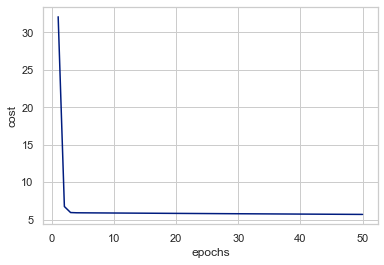

In [21]:
ax = sns.lineplot(data=cost_dataV,x='epochs',y='cost')
ax.set_xlabel('epochs')
ax.set_ylabel('cost')
plt.show()
#可以看到从第二轮代价数据变换很大，接下来平稳了

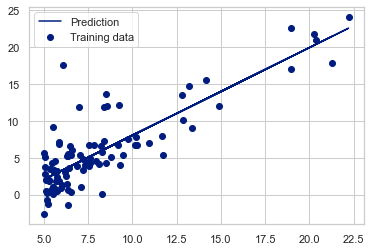

In [22]:
b = final_theta[0] # intercept，Y轴上的截距   a * x + b = y
m = final_theta[1] # slope，斜率

plt.scatter(df.population, df.profit, label="Training data")
plt.plot(df.population, df.population*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()

# 3- 选修章节

In [23]:
raw_data = pd.read_csv('ex1data2.txt', names=['square', 'bedrooms', 'price'])
raw_data.head()

square  bedrooms   price
0    2104         3  399900
1    1600         3  329900
2    2400         3  369000
3    1416         2  232000
4    3000         4  539900

# 标准化数据
最简单的方法是令：

 

其中  是平均值，sn 是标准差。


In [24]:
def normalize_feature(df):
#     """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [25]:
data = normalize_feature(raw_data)
data.head()

square  bedrooms     price
0  0.130010 -0.223675  0.475747
1 -0.504190 -0.223675 -0.084074
2  0.502476 -0.223675  0.228626
3 -0.735723 -1.537767 -0.867025
4  1.257476  1.090417  1.595389

# 2. multi-var batch gradient decent（多变量批量梯度下降）

In [26]:
X = get_X(data)
print(X.shape, type(X))

y = get_y(data)
print(y.shape, type(y))#看下数据的维度和类型

(47, 3) <class 'numpy.ndarray'>
(47,) <class 'numpy.ndarray'>


In [27]:
alpha = 0.01#学习率
theta = np.zeros(X.shape[1])#X.shape[1]：特征数n
epoch = 5000#轮数

In [28]:
final_theta, cost_data = batch_gradient_decent(theta, X, y, epoch, alpha=alpha)

训练轮数: 0 | 误差: 0.48054910410767182061 | 参数矩阵: [-8.97627126e-19  8.36796367e-03  4.32851306e-03]
训练轮数: 1 | 误差: 0.47198587701203859046 | 参数矩阵: [-1.65352365e-18  1.66303056e-02  8.56880107e-03]
训练轮数: 2 | 误差: 0.46366461618706267256 | 参数矩阵: [-2.40942018e-18  2.47885430e-02  1.27223064e-02]
训练轮数: 3 | 误差: 0.45557814005252983414 | 参数矩阵: [-3.35429084e-18  3.28441704e-02  1.67904489e-02]
训练轮数: 4 | 误差: 0.44771948335326100521 | 参数矩阵: [-4.20467443e-18  4.07986599e-02  2.07746264e-02]
训练轮数: 5 | 误差: 0.44008189061506436390 | 参数矩阵: [-5.10230156e-18  4.86534616e-02  2.46762151e-02]
训练轮数: 6 | 误差: 0.43265880979889004276 | 参数矩阵: [-6.28338988e-18  5.64100037e-02  2.84965695e-02]
训练轮数: 7 | 误差: 0.42544388614718725572 | 参数矩阵: [-7.13377348e-18  6.40696932e-02  3.22370232e-02]
训练轮数: 8 | 误差: 0.41843095621663484174 | 参数矩阵: [-8.03140060e-18  7.16339158e-02  3.58988891e-02]
训练轮数: 9 | 误差: 0.41161404209160362688 | 参数矩阵: [-9.02351480e-18  7.91040367e-02  3.94834595e-02]
训练轮数: 10 | 误差: 0.40498734577287159864 | 参数矩阵: [-9.

训练轮数: 695 | 误差: 0.13091942449740970322 | 参数矩阵: [-1.10691598e-16  8.61499724e-01 -2.99311482e-02]
训练轮数: 696 | 误差: 0.13091742237378506397 | 参数矩阵: [-1.10738841e-16  8.61600026e-01 -3.00311671e-02]
训练轮数: 697 | 误差: 0.13091543745821990208 | 参数矩阵: [-1.10549867e-16  8.61699896e-01 -3.01307569e-02]
训练轮数: 698 | 误差: 0.13091346960281075029 | 参数矩阵: [-1.10975059e-16  8.61799333e-01 -3.02299192e-02]
训练轮数: 699 | 误差: 0.13091151866092537448 | 参数矩阵: [-1.10975059e-16  8.61898341e-01 -3.03286560e-02]
训练轮数: 700 | 误差: 0.13090958448719192120 | 参数矩阵: [-1.11164033e-16  8.61996921e-01 -3.04269691e-02]
训练轮数: 701 | 误差: 0.13090766693748809302 | 参数矩阵: [-1.10927815e-16  8.62095075e-01 -3.05248603e-02]
训练轮数: 702 | 误差: 0.13090576586893035160 | 参数矩阵: [-1.11116790e-16  8.62192805e-01 -3.06223312e-02]
训练轮数: 703 | 误差: 0.13090388113986328733 | 参数矩阵: [-1.10975059e-16  8.62290113e-01 -3.07193839e-02]
训练轮数: 704 | 误差: 0.13090201260984909992 | 参数矩阵: [-1.11305764e-16  8.62387000e-01 -3.08160199e-02]
训练轮数: 705 | 误差: 0.130900160139

训练轮数: 1492 | 误差: 0.13068672010802637184 | 参数矩阵: [-1.10833328e-16  8.84020153e-01 -5.24329847e-02]
训练轮数: 1493 | 误差: 0.13068671804896442312 | 参数矩阵: [-1.10927815e-16  8.84023365e-01 -5.24361968e-02]
训练轮数: 1494 | 误差: 0.13068671600759987350 | 参数矩阵: [-1.10975059e-16  8.84026563e-01 -5.24393950e-02]
训练轮数: 1495 | 误差: 0.13068671398378053916 | 参数矩阵: [-1.11211277e-16  8.84029748e-01 -5.24425795e-02]
训练轮数: 1496 | 误差: 0.13068671197735562406 | 参数矩阵: [-1.11116790e-16  8.84032918e-01 -5.24457503e-02]
训练轮数: 1497 | 误差: 0.13068670998817569218 | 参数矩阵: [-1.11022302e-16  8.84036075e-01 -5.24489074e-02]
训练轮数: 1498 | 误差: 0.13068670801609241772 | 参数矩阵: [-1.10738841e-16  8.84039219e-01 -5.24520509e-02]
训练轮数: 1499 | 误差: 0.13068670606095897369 | 参数矩阵: [-1.10833328e-16  8.84042349e-01 -5.24551809e-02]
训练轮数: 1500 | 误差: 0.13068670412262961555 | 参数矩阵: [-1.10738841e-16  8.84045465e-01 -5.24582974e-02]
训练轮数: 1501 | 误差: 0.13068670220095995882 | 参数矩阵: [-1.10738841e-16  8.84048569e-01 -5.24614004e-02]
训练轮数: 1502 | 误差: 0.1

训练轮数: 2285 | 误差: 0.13068648079408018425 | 参数矩阵: [-1.10880572e-16  8.84741653e-01 -5.31544847e-02]
训练轮数: 2286 | 误差: 0.13068648079188818767 | 参数矩阵: [-1.10691598e-16  8.84741758e-01 -5.31545895e-02]
训练轮数: 2287 | 误差: 0.13068648078971500937 | 参数矩阵: [-1.10927815e-16  8.84741862e-01 -5.31546939e-02]
训练轮数: 2288 | 误差: 0.13068648078756048281 | 参数矩阵: [-1.10786085e-16  8.84741966e-01 -5.31547978e-02]
训练轮数: 2289 | 误差: 0.13068648078542452473 | 参数矩阵: [-1.10691598e-16  8.84742069e-01 -5.31549012e-02]
训练轮数: 2290 | 误差: 0.13068648078330688533 | 参数矩阵: [-1.10738841e-16  8.84742172e-01 -5.31550043e-02]
训练轮数: 2291 | 误差: 0.13068648078120745359 | 参数矩阵: [-1.10597111e-16  8.84742275e-01 -5.31551068e-02]
训练轮数: 2292 | 误差: 0.13068648077912609073 | 参数矩阵: [-1.10360893e-16  8.84742377e-01 -5.31552089e-02]
训练轮数: 2293 | 误差: 0.13068648077706260247 | 参数矩阵: [-1.10455380e-16  8.84742479e-01 -5.31553106e-02]
训练轮数: 2294 | 误差: 0.13068648077501685001 | 参数矩阵: [-1.10549867e-16  8.84742580e-01 -5.31554119e-02]
训练轮数: 2295 | 误差: 0.1

训练轮数: 3037 | 误差: 0.13068648053942874543 | 参数矩阵: [-1.10927815e-16  8.84765040e-01 -5.31778720e-02]
训练轮数: 3038 | 误差: 0.13068648053942544252 | 参数矩阵: [-1.11069546e-16  8.84765044e-01 -5.31778760e-02]
训练轮数: 3039 | 误差: 0.13068648053942213960 | 参数矩阵: [-1.10833328e-16  8.84765048e-01 -5.31778801e-02]
训练轮数: 3040 | 误差: 0.13068648053941886444 | 参数矩阵: [-1.10644354e-16  8.84765052e-01 -5.31778842e-02]
训练轮数: 3041 | 误差: 0.13068648053941561704 | 参数矩阵: [-1.10833328e-16  8.84765056e-01 -5.31778882e-02]
训练轮数: 3042 | 误差: 0.13068648053941239739 | 参数矩阵: [-1.10786085e-16  8.84765060e-01 -5.31778922e-02]
训练轮数: 3043 | 误差: 0.13068648053940920550 | 参数矩阵: [-1.10738841e-16  8.84765064e-01 -5.31778962e-02]
训练轮数: 3044 | 误差: 0.13068648053940606912 | 参数矩阵: [-1.10786085e-16  8.84765068e-01 -5.31779002e-02]
训练轮数: 3045 | 误差: 0.13068648053940293274 | 参数矩阵: [-1.10738841e-16  8.84765072e-01 -5.31779041e-02]
训练轮数: 3046 | 误差: 0.13068648053939985187 | 参数矩阵: [-1.10786085e-16  8.84765076e-01 -5.31779081e-02]
训练轮数: 3047 | 误差: 0.1

训练轮数: 3853 | 误差: 0.13068648053904230455 | 参数矩阵: [-1.11069546e-16  8.84765960e-01 -5.31787917e-02]
训练轮数: 3854 | 误差: 0.13068648053904227679 | 参数矩阵: [-1.10738841e-16  8.84765960e-01 -5.31787918e-02]
训练轮数: 3855 | 误差: 0.13068648053904227679 | 参数矩阵: [-1.10691598e-16  8.84765960e-01 -5.31787919e-02]
训练轮数: 3856 | 误差: 0.13068648053904227679 | 参数矩阵: [-1.10833328e-16  8.84765960e-01 -5.31787920e-02]
训练轮数: 3857 | 误差: 0.13068648053904227679 | 参数矩阵: [-1.10927815e-16  8.84765960e-01 -5.31787921e-02]
训练轮数: 3858 | 误差: 0.13068648053904227679 | 参数矩阵: [-1.10927815e-16  8.84765960e-01 -5.31787923e-02]
训练轮数: 3859 | 误差: 0.13068648053904227679 | 参数矩阵: [-1.10786085e-16  8.84765961e-01 -5.31787924e-02]
训练轮数: 3860 | 误差: 0.13068648053904227679 | 参数矩阵: [-1.10975059e-16  8.84765961e-01 -5.31787925e-02]
训练轮数: 3861 | 误差: 0.13068648053904227679 | 参数矩阵: [-1.11022302e-16  8.84765961e-01 -5.31787926e-02]
训练轮数: 3862 | 误差: 0.13068648053904227679 | 参数矩阵: [-1.10691598e-16  8.84765961e-01 -5.31787927e-02]
训练轮数: 3863 | 误差: 0.1

训练轮数: 4661 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10691598e-16  8.84765987e-01 -5.31788188e-02]
训练轮数: 4662 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10927815e-16  8.84765987e-01 -5.31788188e-02]
训练轮数: 4663 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10880572e-16  8.84765987e-01 -5.31788188e-02]
训练轮数: 4664 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.11022302e-16  8.84765987e-01 -5.31788188e-02]
训练轮数: 4665 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.10975059e-16  8.84765987e-01 -5.31788188e-02]
训练轮数: 4666 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.11211277e-16  8.84765987e-01 -5.31788188e-02]
训练轮数: 4667 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.11022302e-16  8.84765987e-01 -5.31788188e-02]
训练轮数: 4668 | 误差: 0.13068648053904191597 | 参数矩阵: [-1.10786085e-16  8.84765987e-01 -5.31788188e-02]
训练轮数: 4669 | 误差: 0.13068648053904191597 | 参数矩阵: [-1.10833328e-16  8.84765987e-01 -5.31788188e-02]
训练轮数: 4670 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10927815e-16  8.84765987e-01 -5.31788188e-02]
训练轮数: 4671 | 误差: 0.1

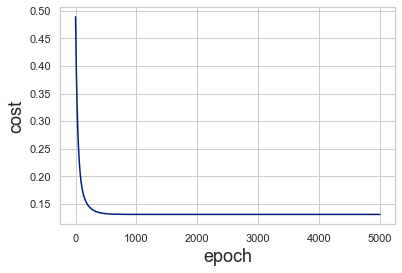

In [29]:
sns.lineplot(x=np.arange(len(cost_data)), y = cost_data)
plt.xlabel('epoch', fontsize=18)
plt.ylabel('cost', fontsize=18)
plt.show()

In [30]:
final_theta

array([-1.10549867e-16,  8.84765988e-01, -5.31788195e-02])

# 3. learning rate（学习率）

In [31]:
base = np.logspace(-1, -5, num=4)
candidate = np.sort(np.concatenate((base, base*3)))
print(candidate)

[1.00000000e-05 3.00000000e-05 2.15443469e-04 6.46330407e-04
 4.64158883e-03 1.39247665e-02 1.00000000e-01 3.00000000e-01]


In [32]:
float(6.46330407e-04)

0.000646330407

训练轮数: 0 | 误差: 0.48935282630680770888 | 参数矩阵: [-8.97627126e-22  8.36796367e-06  4.32851306e-06]
训练轮数: 1 | 误差: 0.48934395073909631169 | 参数矩阵: [-1.88974132e-21  1.67358217e-05  8.65693790e-06]
训练轮数: 2 | 误差: 0.48933507542451831762 | 参数矩阵: [-2.74012491e-21  2.51035742e-05  1.29852745e-05]
训练轮数: 3 | 误差: 0.48932620036306567757 | 参数矩阵: [-3.73223910e-21  3.34712210e-05  1.73135229e-05]
训练轮数: 4 | 误差: 0.48931732555473106405 | 参数矩阵: [-4.44089210e-21  4.18387622e-05  2.16416831e-05]
训练轮数: 5 | 误差: 0.48930845099950670551 | 参数矩阵: [-5.33851922e-21  5.02061978e-05  2.59697550e-05]
训练轮数: 6 | 误差: 0.48929957669738538550 | 参数矩阵: [-6.28338988e-21  5.85735277e-05  3.02977387e-05]
训练轮数: 7 | 误差: 0.48929070264835911042 | 参数矩阵: [-7.03928641e-21  6.69407521e-05  3.46256343e-05]
训练轮数: 8 | 误差: 0.48928182885242055278 | 参数矩阵: [-7.88967000e-21  7.53078708e-05  3.89534416e-05]
训练轮数: 9 | 误差: 0.48927295530956205205 | 参数矩阵: [-8.97627126e-21  8.36748840e-05  4.32811607e-05]
训练轮数: 10 | 误差: 0.48926408201977605872 | 参数矩阵: [-9.

训练轮数: 670 | 误差: 0.48346255073608113140 | 参数矩阵: [-5.93189800e-19  5.59123730e-03  2.88467271e-03]
训练轮数: 671 | 误差: 0.48345384308120115113 | 参数矩阵: [-5.93945696e-19  5.59953473e-03  2.88894235e-03]
训练轮数: 672 | 误差: 0.48344513567442998214 | 参数矩阵: [-5.94654349e-19  5.60783206e-03  2.89321190e-03]
训练轮数: 673 | 误差: 0.48343642851576013042 | 参数矩阵: [-5.95599220e-19  5.61612928e-03  2.89748136e-03]
训练轮数: 674 | 误差: 0.48342772160518421298 | 参数矩阵: [-5.96685821e-19  5.62442640e-03  2.90175073e-03]
训练轮数: 675 | 误差: 0.48341901494269479134 | 参数矩阵: [-5.97441718e-19  5.63272341e-03  2.90602002e-03]
训练轮数: 676 | 误差: 0.48341030852828453801 | 参数矩阵: [-5.98292101e-19  5.64102032e-03  2.91028922e-03]
训练轮数: 677 | 误差: 0.48340160236194568144 | 参数矩阵: [-5.99142485e-19  5.64931713e-03  2.91455834e-03]
训练轮数: 678 | 误差: 0.48339289644367117171 | 参数矩阵: [-6.00229086e-19  5.65761383e-03  2.91882736e-03]
训练轮数: 679 | 误差: 0.48338419077345362584 | 参数矩阵: [-6.01362931e-19  5.66591042e-03  2.92309630e-03]
训练轮数: 680 | 误差: 0.483375485351

训练轮数: 800 | 误差: 0.48233263334056097893 | 参数矩阵: [-7.08464020e-19  6.66902678e-03  3.43899436e-03]
训练轮数: 801 | 误差: 0.48232395787765897088 | 参数矩阵: [-7.09456135e-19  6.67731062e-03  3.44325266e-03]
训练轮数: 802 | 误差: 0.48231528266190265564 | 参数矩阵: [-7.10353762e-19  6.68559436e-03  3.44751088e-03]
训练轮数: 803 | 误差: 0.48230660769328459470 | 参数矩阵: [-7.11487606e-19  6.69387800e-03  3.45176901e-03]
训练轮数: 804 | 误差: 0.48229793297179746059 | 参数矩阵: [-7.12526964e-19  6.70216153e-03  3.45602705e-03]
训练轮数: 805 | 误差: 0.48228925849743375931 | 参数矩阵: [-7.13519078e-19  6.71044496e-03  3.46028501e-03]
训练轮数: 806 | 误差: 0.48228058427018616339 | 参数矩阵: [-7.14416705e-19  6.71872828e-03  3.46454288e-03]
训练轮数: 807 | 误差: 0.48227191029004717882 | 参数矩阵: [-7.15550550e-19  6.72701150e-03  3.46880066e-03]
训练轮数: 808 | 误差: 0.48226323655700964466 | 参数矩阵: [-7.16637152e-19  6.73529461e-03  3.47305836e-03]
训练轮数: 809 | 误差: 0.48225456307106595588 | 参数矩阵: [-7.17440292e-19  6.74357762e-03  3.47731597e-03]
训练轮数: 810 | 误差: 0.482245889832

训练轮数: 1495 | 误差: 0.47636237976738099453 | 参数矩阵: [-1.32244097e-18  1.24012013e-02  6.37759559e-03]
训练轮数: 1496 | 误差: 0.47635387430006009835 | 参数矩阵: [-1.32329136e-18  1.24094129e-02  6.38179372e-03]
训练轮数: 1497 | 误差: 0.47634536907479996248 | 参数矩阵: [-1.32423623e-18  1.24176245e-02  6.38599176e-03]
训练轮数: 1498 | 误差: 0.47633686409159342601 | 参数矩阵: [-1.32537007e-18  1.24258359e-02  6.39018972e-03]
训练轮数: 1499 | 误差: 0.47632835935043321696 | 参数矩阵: [-1.32631494e-18  1.24340472e-02  6.39438759e-03]
训练轮数: 1500 | 误差: 0.47631985485131211888 | 参数矩阵: [-1.32697635e-18  1.24422585e-02  6.39858537e-03]
训练轮数: 1501 | 误差: 0.47631135059422285982 | 参数矩阵: [-1.32787398e-18  1.24504696e-02  6.40278307e-03]
训练轮数: 1502 | 误差: 0.47630284657915822333 | 参数矩阵: [-1.32862988e-18  1.24586806e-02  6.40698068e-03]
训练轮数: 1503 | 误差: 0.47629434280611099295 | 参数矩阵: [-1.32943302e-18  1.24668915e-02  6.41117821e-03]
训练轮数: 1504 | 误差: 0.47628583927507395224 | 参数矩阵: [-1.33028340e-18  1.24751023e-02  6.41537565e-03]
训练轮数: 1505 | 误差: 0.4

训练轮数: 1612 | 误差: 0.47536888083397793592 | 参数矩阵: [-1.42547912e-18  1.33612618e-02  6.86819281e-03]
训练轮数: 1613 | 误差: 0.47536040363870341041 | 参数矩阵: [-1.42632950e-18  1.33694613e-02  6.87238088e-03]
训练轮数: 1614 | 误差: 0.47535192668464404386 | 参数矩阵: [-1.42717989e-18  1.33776608e-02  6.87656886e-03]
训练轮数: 1615 | 误差: 0.47534344997179278636 | 参数矩阵: [-1.42803027e-18  1.33858601e-02  6.88075675e-03]
训练轮数: 1616 | 误差: 0.47533497350014242144 | 参数矩阵: [-1.42878617e-18  1.33940594e-02  6.88494456e-03]
训练轮数: 1617 | 误差: 0.47532649726968567716 | 参数矩阵: [-1.42968379e-18  1.34022585e-02  6.88913228e-03]
训练轮数: 1618 | 误差: 0.47531802128041550359 | 参数矩阵: [-1.43048693e-18  1.34104575e-02  6.89331992e-03]
训练轮数: 1619 | 误差: 0.47530954553232435122 | 参数矩阵: [-1.43124283e-18  1.34186565e-02  6.89750747e-03]
训练轮数: 1620 | 误差: 0.47530107002540533667 | 参数矩阵: [-1.43218770e-18  1.34268553e-02  6.90169493e-03]
训练轮数: 1621 | 误差: 0.47529259475965118797 | 参数矩阵: [-1.43289635e-18  1.34350540e-02  6.90588231e-03]
训练轮数: 1622 | 误差: 0.4

训练轮数: 2346 | 误差: 0.46921103819231213539 | 参数矩阵: [-2.07781782e-18  1.93520673e-02  9.91920963e-03]
训练轮数: 2347 | 误差: 0.46920273612280993802 | 参数矩阵: [-2.07885718e-18  1.93601915e-02  9.92333500e-03]
训练轮数: 2348 | 误差: 0.46919443428928675477 | 参数矩阵: [-2.07984930e-18  1.93683156e-02  9.92746029e-03]
训练轮数: 2349 | 误差: 0.46918613269173548019 | 参数矩阵: [-2.08074692e-18  1.93764396e-02  9.93158549e-03]
训练轮数: 2350 | 误差: 0.46917783133014895336 | 参数矩阵: [-2.08164455e-18  1.93845635e-02  9.93571061e-03]
训练轮数: 2351 | 误差: 0.46916953020452029088 | 参数矩阵: [-2.08258942e-18  1.93926873e-02  9.93983564e-03]
训练轮数: 2352 | 误差: 0.46916122931484222081 | 参数矩阵: [-2.08353429e-18  1.94008110e-02  9.94396059e-03]
训练轮数: 2353 | 误差: 0.46915292866110797076 | 参数矩阵: [-2.08433743e-18  1.94089346e-02  9.94808545e-03]
训练轮数: 2354 | 误差: 0.46914462824331037982 | 参数矩阵: [-2.08528230e-18  1.94170581e-02  9.95221023e-03]
训练轮数: 2355 | 误差: 0.46913632806144234255 | 参数矩阵: [-2.08632166e-18  1.94251814e-02  9.95633492e-03]
训练轮数: 2356 | 误差: 0.4

训练轮数: 2526 | 误差: 0.46772046056849875262 | 参数矩阵: [-2.23702853e-18  2.08127792e-02  1.06604101e-02]
训练轮数: 2527 | 误差: 0.46771220086176018560 | 参数矩阵: [-2.23787891e-18  2.08208850e-02  1.06645203e-02]
训练轮数: 2528 | 误差: 0.46770394138973403475 | 参数矩阵: [-2.23906000e-18  2.08289908e-02  1.06686303e-02]
训练轮数: 2529 | 误差: 0.46769568215241358322 | 参数矩阵: [-2.24005212e-18  2.08370964e-02  1.06727402e-02]
训练轮数: 2530 | 误差: 0.46768742314979139252 | 参数矩阵: [-2.24090250e-18  2.08452019e-02  1.06768501e-02]
训练轮数: 2531 | 误差: 0.46767916438186091233 | 参数矩阵: [-2.24194186e-18  2.08533074e-02  1.06809599e-02]
训练轮数: 2532 | 误差: 0.46767090584861475966 | 参数矩阵: [-2.24265051e-18  2.08614127e-02  1.06850695e-02]
训练轮数: 2533 | 误差: 0.46766264755004610665 | 参数矩阵: [-2.24359538e-18  2.08695179e-02  1.06891791e-02]
训练轮数: 2534 | 误差: 0.46765438948614795889 | 参数矩阵: [-2.24458749e-18  2.08776230e-02  1.06932887e-02]
训练轮数: 2535 | 误差: 0.46764613165691315544 | 参数矩阵: [-2.24548512e-18  2.08857281e-02  1.06973981e-02]
训练轮数: 2536 | 误差: 0.4

训练轮数: 3153 | 误差: 0.46258740150240507116 | 参数矩阵: [-2.79927382e-18  2.58752101e-02  1.32208941e-02]
训练轮数: 3154 | 误差: 0.46257928759214300696 | 参数矩阵: [-2.80036042e-18  2.58832524e-02  1.32249514e-02]
训练轮数: 3155 | 误差: 0.46257117391223573355 | 参数矩阵: [-2.80121080e-18  2.58912945e-02  1.32290087e-02]
训练轮数: 3156 | 误差: 0.46256306046267653409 | 参数矩阵: [-2.80210843e-18  2.58993366e-02  1.32330658e-02]
训练轮数: 3157 | 误差: 0.46255494724345835866 | 参数矩阵: [-2.80291157e-18  2.59073785e-02  1.32371229e-02]
训练轮数: 3158 | 误差: 0.46254683425457443491 | 参数矩阵: [-2.80404541e-18  2.59154204e-02  1.32411798e-02]
训练轮数: 3159 | 误差: 0.46253872149601782393 | 参数矩阵: [-2.80494304e-18  2.59234621e-02  1.32452367e-02]
训练轮数: 3160 | 误差: 0.46253060896778164235 | 参数矩阵: [-2.80584067e-18  2.59315038e-02  1.32492935e-02]
训练轮数: 3161 | 误差: 0.46252249666985906229 | 参数矩阵: [-2.80683278e-18  2.59395453e-02  1.32533502e-02]
训练轮数: 3162 | 误差: 0.46251438460224303384 | 参数矩阵: [-2.80777765e-18  2.59475868e-02  1.32574069e-02]
训练轮数: 3163 | 误差: 0.4

训练轮数: 3352 | 误差: 0.46097726268870592436 | 参数矩阵: [-2.98262597e-18  2.74736328e-02  1.40266494e-02]
训练轮数: 3353 | 误差: 0.46096919448370865524 | 参数矩阵: [-2.98342911e-18  2.74816550e-02  1.40306900e-02]
训练轮数: 3354 | 误差: 0.46096112650770015851 | 参数矩阵: [-2.98427949e-18  2.74896771e-02  1.40347306e-02]
训练轮数: 3355 | 误差: 0.46095305876067399486 | 参数矩阵: [-2.98522436e-18  2.74976991e-02  1.40387711e-02]
训练轮数: 3356 | 误差: 0.46094499124262316991 | 参数矩阵: [-2.98602750e-18  2.75057210e-02  1.40428115e-02]
训练轮数: 3357 | 误差: 0.46093692395354091129 | 参数矩阵: [-2.98739756e-18  2.75137428e-02  1.40468519e-02]
训练轮数: 3358 | 误差: 0.46092885689342028011 | 参数矩阵: [-2.98834243e-18  2.75217645e-02  1.40508921e-02]
训练轮数: 3359 | 误差: 0.46092079006225450399 | 参数矩阵: [-2.98928730e-18  2.75297861e-02  1.40549323e-02]
训练轮数: 3360 | 误差: 0.46091272346003675509 | 参数矩阵: [-2.99027942e-18  2.75378076e-02  1.40589723e-02]
训练轮数: 3361 | 误差: 0.46090465708676015000 | 参数矩阵: [-2.99089358e-18  2.75458290e-02  1.40630123e-02]
训练轮数: 3362 | 误差: 0.4

训练轮数: 3991 | 误差: 0.45586806231256016275 | 参数矩阵: [-3.56069784e-18  3.25793618e-02  1.65916675e-02]
训练轮数: 3992 | 误差: 0.45586013904570804600 | 参数矩阵: [-3.56126476e-18  3.25873200e-02  1.65956550e-02]
训练轮数: 3993 | 误差: 0.45585221600351466531 | 参数矩阵: [-3.56216239e-18  3.25952781e-02  1.65996425e-02]
训练轮数: 3994 | 误差: 0.45584429318597319281 | 参数矩阵: [-3.56306001e-18  3.26032360e-02  1.66036299e-02]
训练轮数: 3995 | 误差: 0.45583637059307702266 | 参数矩阵: [-3.56400488e-18  3.26111939e-02  1.66076173e-02]
训练轮数: 3996 | 误差: 0.45582844822481949354 | 参数矩阵: [-3.56466629e-18  3.26191517e-02  1.66116045e-02]
训练轮数: 3997 | 误差: 0.45582052608119366655 | 参数矩阵: [-3.56532770e-18  3.26271094e-02  1.66155917e-02]
训练轮数: 3998 | 误差: 0.45581260416219310239 | 参数矩阵: [-3.56636706e-18  3.26350669e-02  1.66195788e-02]
训练轮数: 3999 | 误差: 0.45580468246781086217 | 参数矩阵: [-3.56698123e-18  3.26430244e-02  1.66235658e-02]
训练轮数: 4000 | 误差: 0.45579676099804045108 | 参数矩阵: [-3.56787885e-18  3.26509818e-02  1.66275527e-02]
训练轮数: 4001 | 误差: 0.4

训练轮数: 4174 | 误差: 0.45442183898607124704 | 参数矩阵: [-3.72449116e-18  3.40340475e-02  1.73200187e-02]
训练轮数: 4175 | 误差: 0.45441395672020262753 | 参数矩阵: [-3.72538879e-18  3.40419874e-02  1.73239912e-02]
训练轮数: 4176 | 误差: 0.45440607467776800155 | 参数矩阵: [-3.72619193e-18  3.40499273e-02  1.73279636e-02]
训练轮数: 4177 | 误差: 0.45439819285876048571 | 参数矩阵: [-3.72718405e-18  3.40578670e-02  1.73319359e-02]
训练轮数: 4178 | 误差: 0.45439031126317369624 | 参数矩阵: [-3.72812892e-18  3.40658067e-02  1.73359081e-02]
训练轮数: 4179 | 误差: 0.45438242989100074976 | 参数矩阵: [-3.72897930e-18  3.40737462e-02  1.73398802e-02]
训练轮数: 4180 | 误差: 0.45437454874223509593 | 参数矩阵: [-3.72978244e-18  3.40816857e-02  1.73438523e-02]
训练轮数: 4181 | 误差: 0.45436666781687007344 | 参数矩阵: [-3.73091629e-18  3.40896250e-02  1.73478243e-02]
训练轮数: 4182 | 误差: 0.45435878711489879889 | 参数矩阵: [-3.73190840e-18  3.40975642e-02  1.73517962e-02]
训练轮数: 4183 | 误差: 0.45435090663631472196 | 参数矩阵: [-3.73285327e-18  3.41055034e-02  1.73557680e-02]
训练轮数: 4184 | 误差: 0.4

训练轮数: 4798 | 误差: 0.44954646757322058725 | 参数矩阵: [-4.28503568e-18  3.89692916e-02  1.97828809e-02]
训练轮数: 4799 | 误差: 0.44953872344098000369 | 参数矩阵: [-4.28602780e-18  3.89771697e-02  1.97868022e-02]
训练轮数: 4800 | 误差: 0.44953097952804788040 | 参数矩阵: [-4.28701991e-18  3.89850478e-02  1.97907234e-02]
训练轮数: 4801 | 误差: 0.44952323583441772259 | 参数矩阵: [-4.28791754e-18  3.89929257e-02  1.97946446e-02]
训练轮数: 4802 | 误差: 0.44951549236008292443 | 参数矩阵: [-4.28886241e-18  3.90008036e-02  1.97985657e-02]
训练轮数: 4803 | 误差: 0.44950774910503682458 | 参数矩阵: [-4.28985452e-18  3.90086813e-02  1.98024867e-02]
训练轮数: 4804 | 误差: 0.44950000606927315028 | 参数矩阵: [-4.29079939e-18  3.90165589e-02  1.98064076e-02]
训练轮数: 4805 | 误差: 0.44949226325278512917 | 参数矩阵: [-4.29179151e-18  3.90244365e-02  1.98103284e-02]
训练轮数: 4806 | 误差: 0.44948452065556626644 | 参数矩阵: [-4.29254740e-18  3.90323139e-02  1.98142492e-02]
训练轮数: 4807 | 误差: 0.44947677827760995628 | 参数矩阵: [-4.29358676e-18  3.90401913e-02  1.98181698e-02]
训练轮数: 4808 | 误差: 0.4

训练轮数: 4950 | 误差: 0.44837187250310461817 | 参数矩阵: [-4.42166398e-18  4.01656384e-02  2.03779865e-02]
训练轮数: 4951 | 误差: 0.44836416163070996754 | 参数矩阵: [-4.42260885e-18  4.01735016e-02  2.03818954e-02]
训练轮数: 4952 | 误差: 0.44835645097663062719 | 参数矩阵: [-4.42350648e-18  4.01813646e-02  2.03858043e-02]
训练轮数: 4953 | 误差: 0.44834874054086010231 | 参数矩阵: [-4.42435686e-18  4.01892276e-02  2.03897131e-02]
训练轮数: 4954 | 误差: 0.44834103032339184258 | 参数矩阵: [-4.42539622e-18  4.01970905e-02  2.03936218e-02]
训练轮数: 4955 | 误差: 0.44833332032421935320 | 参数矩阵: [-4.42648282e-18  4.02049533e-02  2.03975304e-02]
训练轮数: 4956 | 误差: 0.44832561054333613937 | 参数矩阵: [-4.42719147e-18  4.02128159e-02  2.04014389e-02]
训练轮数: 4957 | 误差: 0.44831790098073570627 | 参数矩阵: [-4.42799461e-18  4.02206785e-02  2.04053474e-02]
训练轮数: 4958 | 误差: 0.44831019163641128156 | 参数矩阵: [-4.42865602e-18  4.02285410e-02  2.04092558e-02]
训练轮数: 4959 | 误差: 0.44830248251035681450 | 参数矩阵: [-4.42955365e-18  4.02364034e-02  2.04131640e-02]
训练轮数: 4960 | 误差: 0.4

训练轮数: 584 | 误差: 0.47416731976388798442 | 参数矩阵: [-1.54684776e-18  1.45247465e-02  7.46218903e-03]
训练轮数: 585 | 误差: 0.47414199109864602066 | 参数矩阵: [-1.54968237e-18  1.45493012e-02  7.47471666e-03]
训练轮数: 586 | 误差: 0.47411666459507606497 | 参数矩阵: [-1.55209179e-18  1.45738551e-02  7.48724351e-03]
训练轮数: 587 | 误差: 0.47409134025298421689 | 参数矩阵: [-1.55506813e-18  1.45984079e-02  7.49976960e-03]
训练轮数: 588 | 误差: 0.47406601807217652045 | 参数矩阵: [-1.55733582e-18  1.46229599e-02  7.51229491e-03]
训练轮数: 589 | 误差: 0.47404069805245918623 | 参数矩阵: [-1.55960351e-18  1.46475109e-02  7.52481945e-03]
训练轮数: 590 | 误差: 0.47401538019363814724 | 参数矩阵: [-1.56229639e-18  1.46720610e-02  7.53734322e-03]
训练轮数: 591 | 误差: 0.47399006449551978060 | 参数矩阵: [-1.56442235e-18  1.46966102e-02  7.54986622e-03]
训练轮数: 592 | 误差: 0.47396475095791007481 | 参数矩阵: [-1.56654831e-18  1.47211584e-02  7.56238844e-03]
训练轮数: 593 | 误差: 0.47393943958061540700 | 参数矩阵: [-1.56980811e-18  1.47457057e-02  7.57490990e-03]
训练轮数: 594 | 误差: 0.473914130363

训练轮数: 709 | 误差: 0.47101792811875198286 | 参数矩阵: [-1.88076505e-18  1.75869166e-02  9.02217487e-03]
训练轮数: 710 | 误差: 0.47099286816521090948 | 参数矩阵: [-1.88331620e-18  1.76113557e-02  9.03460634e-03]
训练轮数: 711 | 误差: 0.47096781034923801412 | 参数矩阵: [-1.88544216e-18  1.76357940e-02  9.04703705e-03]
训练轮数: 712 | 误差: 0.47094275467064150575 | 参数矩阵: [-1.88756812e-18  1.76602313e-02  9.05946699e-03]
训练轮数: 713 | 误差: 0.47091770112922964886 | 参数矩阵: [-1.88983581e-18  1.76846677e-02  9.07189617e-03]
训练轮数: 714 | 误差: 0.47089264972481081895 | 参数矩阵: [-1.89252869e-18  1.77091032e-02  9.08432458e-03]
训练轮数: 715 | 误差: 0.47086760045719316947 | 参数矩阵: [-1.89536330e-18  1.77335378e-02  9.09675222e-03]
训练轮数: 716 | 误差: 0.47084255332618518697 | 参数矩阵: [-1.89734753e-18  1.77579714e-02  9.10917910e-03]
训练轮数: 717 | 误差: 0.47081750833159519143 | 参数矩阵: [-1.89989868e-18  1.77824041e-02  9.12160520e-03]
训练轮数: 718 | 误差: 0.47079246547323161387 | 参数矩阵: [-1.90244983e-18  1.78068359e-02  9.13403055e-03]
训练轮数: 719 | 误差: 0.470767424750

训练轮数: 1368 | 误差: 0.45495789782742035445 | 参数矩阵: [-3.65225580e-18  3.34943070e-02  1.70500359e-02]
训练轮数: 1369 | 误差: 0.45493420577932686122 | 参数矩阵: [-3.65551561e-18  3.35181471e-02  1.70619701e-02]
训练轮数: 1370 | 误差: 0.45491051574616364617 | 参数矩阵: [-3.65849195e-18  3.35419863e-02  1.70739036e-02]
训练轮数: 1371 | 误差: 0.45488682772775007601 | 参数矩阵: [-3.66075964e-18  3.35658246e-02  1.70858364e-02]
训练轮数: 1372 | 误差: 0.45486314172390562849 | 参数矩阵: [-3.66359425e-18  3.35896621e-02  1.70977684e-02]
训练轮数: 1373 | 误差: 0.45483945773444961480 | 参数矩阵: [-3.66628713e-18  3.36134986e-02  1.71096996e-02]
训练轮数: 1374 | 误差: 0.45481577575920173473 | 参数矩阵: [-3.66968867e-18  3.36373342e-02  1.71216301e-02]
训练轮数: 1375 | 误差: 0.45479209579798152152 | 参数矩阵: [-3.67309020e-18  3.36611690e-02  1.71335599e-02]
训练轮数: 1376 | 误差: 0.45476841785060828638 | 参数矩阵: [-3.67592481e-18  3.36850028e-02  1.71454889e-02]
训练轮数: 1377 | 误差: 0.45474474191690167357 | 参数矩阵: [-3.67904289e-18  3.37088357e-02  1.71574172e-02]
训练轮数: 1378 | 误差: 0.4

训练轮数: 1540 | 误差: 0.45091234722642420385 | 参数矩阵: [-4.11458102e-18  3.75816586e-02  1.90918350e-02]
训练轮数: 1541 | 误差: 0.45088899910462715281 | 参数矩阵: [-4.11713217e-18  3.76053452e-02  1.91036420e-02]
训练轮数: 1542 | 误差: 0.45086565296694391947 | 参数矩阵: [-4.11968332e-18  3.76290308e-02  1.91154484e-02]
训练轮数: 1543 | 误差: 0.45084230881319703466 | 参数矩阵: [-4.12223447e-18  3.76527155e-02  1.91272540e-02]
训练轮数: 1544 | 误差: 0.45081896664320864065 | 参数矩阵: [-4.12464389e-18  3.76763994e-02  1.91390588e-02]
训练轮数: 1545 | 误差: 0.45079562645680104627 | 参数矩阵: [-4.12776196e-18  3.77000824e-02  1.91508630e-02]
训练轮数: 1546 | 误差: 0.45077228825379661581 | 参数矩阵: [-4.13017138e-18  3.77237645e-02  1.91626663e-02]
训练轮数: 1547 | 误差: 0.45074895203401743604 | 参数矩阵: [-4.13300599e-18  3.77474457e-02  1.91744690e-02]
训练轮数: 1548 | 误差: 0.45072561779728614884 | 参数矩阵: [-4.13612407e-18  3.77711260e-02  1.91862709e-02]
训练轮数: 1549 | 误差: 0.45070228554342478544 | 参数矩阵: [-4.13881695e-18  3.77948054e-02  1.91980721e-02]
训练轮数: 1550 | 误差: 0.4

训练轮数: 2210 | 误差: 0.43570503776327601519 | 参数矩阵: [-5.93936248e-18  5.32541530e-02  2.68393897e-02]
训练轮数: 2211 | 误差: 0.43568297995516835908 | 参数矩阵: [-5.94219709e-18  5.32772520e-02  2.68507116e-02]
训练轮数: 2212 | 误差: 0.43566092401563111247 | 参数矩阵: [-5.94517343e-18  5.33003501e-02  2.68620328e-02]
训练轮数: 2213 | 误差: 0.43563886994449685375 | 参数矩阵: [-5.94857497e-18  5.33234474e-02  2.68733532e-02]
训练轮数: 2214 | 误差: 0.43561681774159871638 | 参数矩阵: [-5.95140958e-18  5.33465437e-02  2.68846730e-02]
训练轮数: 2215 | 误差: 0.43559476740676927875 | 参数矩阵: [-5.95410246e-18  5.33696393e-02  2.68959921e-02]
训练轮数: 2216 | 误差: 0.43557271893984134126 | 参数矩阵: [-5.95679534e-18  5.33927339e-02  2.69073104e-02]
训练轮数: 2217 | 误差: 0.43555067234064775983 | 参数矩阵: [-5.95934649e-18  5.34158277e-02  2.69186280e-02]
训练轮数: 2218 | 误差: 0.43552862760902144590 | 参数矩阵: [-5.96246456e-18  5.34389206e-02  2.69299450e-02]
训练轮数: 2219 | 误差: 0.43550658474479508886 | 参数矩阵: [-5.96515745e-18  5.34620127e-02  2.69412612e-02]
训练轮数: 2220 | 误差: 0.4

训练轮数: 2394 | 误差: 0.43167769020655050172 | 参数矩阵: [-6.44066361e-18  5.74898498e-02  2.89106653e-02]
训练轮数: 2395 | 误差: 0.43165597341520667296 | 参数矩阵: [-6.44307303e-18  5.75127904e-02  2.89218568e-02]
训练轮数: 2396 | 误差: 0.43163425846191588731 | 参数矩阵: [-6.44548245e-18  5.75357301e-02  2.89330475e-02]
训练轮数: 2397 | 误差: 0.43161254534651327663 | 参数矩阵: [-6.44817533e-18  5.75586689e-02  2.89442376e-02]
训练轮数: 2398 | 误差: 0.43159083406883469447 | 参数矩阵: [-6.45100994e-18  5.75816069e-02  2.89554269e-02]
训练轮数: 2399 | 误差: 0.43156912462871566127 | 参数矩阵: [-6.45327763e-18  5.76045440e-02  2.89666155e-02]
训练轮数: 2400 | 误差: 0.43154741702599153097 | 参数矩阵: [-6.45568705e-18  5.76274803e-02  2.89778034e-02]
训练轮数: 2401 | 误差: 0.43152571126049837913 | 参数矩阵: [-6.45923031e-18  5.76504157e-02  2.89889906e-02]
训练轮数: 2402 | 误差: 0.43150400733207122661 | 参数矩阵: [-6.46192320e-18  5.76733503e-02  2.90001772e-02]
训练轮数: 2403 | 误差: 0.43148230524054614898 | 参数矩阵: [-6.46489954e-18  5.76962839e-02  2.90113630e-02]
训练轮数: 2404 | 误差: 0.4

训练轮数: 3022 | 误差: 0.41839475588548485918 | 参数矩阵: [-8.15617077e-18  7.17291799e-02  3.58013627e-02]
训练轮数: 3023 | 误差: 0.41837416161803508974 | 参数矩阵: [-8.15886366e-18  7.17515890e-02  3.58121177e-02]
训练轮数: 3024 | 误差: 0.41835356908824544719 | 参数矩阵: [-8.16169827e-18  7.17739974e-02  3.58228720e-02]
训练轮数: 3025 | 误差: 0.41833297829596050033 | 参数矩阵: [-8.16424942e-18  7.17964049e-02  3.58336256e-02]
训练轮数: 3026 | 误差: 0.41831238924102515098 | 参数矩阵: [-8.16665884e-18  7.18188115e-02  3.58443786e-02]
训练轮数: 3027 | 误差: 0.41829180192328396792 | 参数矩阵: [-8.16920999e-18  7.18412173e-02  3.58551309e-02]
训练轮数: 3028 | 误差: 0.41827121634258146443 | 参数矩阵: [-8.17218633e-18  7.18636223e-02  3.58658824e-02]
训练轮数: 3029 | 误差: 0.41825063249876276439 | 参数矩阵: [-8.17473748e-18  7.18860265e-02  3.58766334e-02]
训练轮数: 3030 | 误差: 0.41823005039167232555 | 参数矩阵: [-8.17700517e-18  7.19084298e-02  3.58873836e-02]
训练轮数: 3031 | 误差: 0.41820947002115488322 | 参数矩阵: [-8.17969805e-18  7.19308323e-02  3.58981331e-02]
训练轮数: 3032 | 误差: 0.4

训练轮数: 3147 | 误差: 0.41583389010042537404 | 参数矩阵: [-8.49575729e-18  7.45238676e-02  3.71404467e-02]
训练轮数: 3148 | 误差: 0.41581351184115367126 | 参数矩阵: [-8.49859190e-18  7.45461727e-02  3.71511164e-02]
训练轮数: 3149 | 误差: 0.41579313530023476186 | 参数矩阵: [-8.50185170e-18  7.45684770e-02  3.71617855e-02]
训练轮数: 3150 | 误差: 0.41577276047751521304 | 参数矩阵: [-8.50496978e-18  7.45907804e-02  3.71724539e-02]
训练轮数: 3151 | 误差: 0.41575238737284142543 | 参数矩阵: [-8.50780439e-18  7.46130830e-02  3.71831216e-02]
训练轮数: 3152 | 误差: 0.41573201598605974416 | 参数矩阵: [-8.51021381e-18  7.46353848e-02  3.71937886e-02]
训练轮数: 3153 | 误差: 0.41571164631701679193 | 参数矩阵: [-8.51262323e-18  7.46576857e-02  3.72044549e-02]
训练轮数: 3154 | 误差: 0.41569127836555891387 | 参数矩阵: [-8.51602476e-18  7.46799858e-02  3.72151206e-02]
训练轮数: 3155 | 误差: 0.41567091213153267715 | 参数矩阵: [-8.51815072e-18  7.47022851e-02  3.72257856e-02]
训练轮数: 3156 | 误差: 0.41565054761478453793 | 参数矩阵: [-8.52098534e-18  7.47245836e-02  3.72364499e-02]
训练轮数: 3157 | 误差: 0.4

训练轮数: 3826 | 误差: 0.40238472806472247445 | 参数矩阵: [-1.03338614e-17  8.94797314e-02  4.42304077e-02]
训练轮数: 3827 | 误差: 0.40236548193165105891 | 参数矩阵: [-1.03369795e-17  8.95014808e-02  4.42406234e-02]
训练轮数: 3828 | 误差: 0.40234623741580549661 | 参数矩阵: [-1.03400976e-17  8.95232294e-02  4.42508384e-02]
训练轮数: 3829 | 误差: 0.40232699451704145854 | 参数矩阵: [-1.03432156e-17  8.95449772e-02  4.42610527e-02]
训练轮数: 3830 | 误差: 0.40230775323521450471 | 参数矩阵: [-1.03457668e-17  8.95667242e-02  4.42712664e-02]
训练轮数: 3831 | 误差: 0.40228851357018030610 | 参数矩阵: [-1.03483179e-17  8.95884703e-02  4.42814795e-02]
训练轮数: 3832 | 误差: 0.40226927552179458925 | 参数矩阵: [-1.03515778e-17  8.96102157e-02  4.42916919e-02]
训练轮数: 3833 | 误差: 0.40225003908991291413 | 参数矩阵: [-1.03548376e-17  8.96319603e-02  4.43019036e-02]
训练轮数: 3834 | 误差: 0.40223080427439117379 | 参数矩阵: [-1.03576722e-17  8.96537040e-02  4.43121146e-02]
训练轮数: 3835 | 误差: 0.40221157107508476169 | 参数矩阵: [-1.03607902e-17  8.96754470e-02  4.43223251e-02]
训练轮数: 3836 | 误差: 0.4

训练轮数: 3940 | 误差: 0.40020105081620682697 | 参数矩阵: [-1.06521884e-17  9.19539757e-02  4.53907667e-02]
训练轮数: 3941 | 误差: 0.40018198812009736498 | 参数矩阵: [-1.06547395e-17  9.19756334e-02  4.54009076e-02]
训练轮数: 3942 | 误差: 0.40016292702483891031 | 参数矩阵: [-1.06581410e-17  9.19972903e-02  4.54110478e-02]
训练轮数: 3943 | 误差: 0.40014386753028868826 | 参数矩阵: [-1.06608339e-17  9.20189463e-02  4.54211875e-02]
训练轮数: 3944 | 误差: 0.40012480963630381314 | 参数矩阵: [-1.06633851e-17  9.20406016e-02  4.54313264e-02]
训练轮数: 3945 | 误差: 0.40010575334274139925 | 参数矩阵: [-1.06656528e-17  9.20622561e-02  4.54414647e-02]
训练轮数: 3946 | 误差: 0.40008669864945861638 | 参数矩阵: [-1.06683456e-17  9.20839097e-02  4.54516024e-02]
训练轮数: 3947 | 误差: 0.40006764555631257885 | 参数矩阵: [-1.06713220e-17  9.21055626e-02  4.54617394e-02]
训练轮数: 3948 | 误差: 0.40004859406316051196 | 参数矩阵: [-1.06737314e-17  9.21272146e-02  4.54718757e-02]
训练轮数: 3949 | 误差: 0.40002954416985964103 | 参数矩阵: [-1.06768495e-17  9.21488659e-02  4.54820114e-02]
训练轮数: 3950 | 误差: 0.4

训练轮数: 4618 | 误差: 0.38763666554496861716 | 参数矩阵: [-1.25427328e-17  1.06455429e-01  5.21179136e-02]
训练轮数: 4619 | 误差: 0.38761865609419426937 | 参数矩阵: [-1.25452840e-17  1.06476550e-01  5.21276186e-02]
训练轮数: 4620 | 误差: 0.38760064815031386454 | 参数矩阵: [-1.25475517e-17  1.06497671e-01  5.21373230e-02]
训练轮数: 4621 | 误差: 0.38758264171319295466 | 参数矩阵: [-1.25508115e-17  1.06518790e-01  5.21470267e-02]
训练轮数: 4622 | 误差: 0.38756463678269731377 | 参数矩阵: [-1.25542130e-17  1.06539909e-01  5.21567297e-02]
训练轮数: 4623 | 误差: 0.38754663335869249385 | 参数矩阵: [-1.25569059e-17  1.06561027e-01  5.21664322e-02]
训练轮数: 4624 | 误差: 0.38752863144104432447 | 参数矩阵: [-1.25597405e-17  1.06582145e-01  5.21761340e-02]
训练轮数: 4625 | 误差: 0.38751063102961841311 | 参数矩阵: [-1.25632837e-17  1.06603261e-01  5.21858352e-02]
训练轮数: 4626 | 误差: 0.38749263212428064485 | 参数矩阵: [-1.25659766e-17  1.06624377e-01  5.21955357e-02]
训练轮数: 4627 | 误差: 0.38747463472489640512 | 参数矩阵: [-1.25688112e-17  1.06645492e-01  5.22052356e-02]
训练轮数: 4628 | 误差: 0.3

训练轮数: 4752 | 误差: 0.38523677455390875624 | 参数矩阵: [-1.29215787e-17  1.09278745e-01  5.34127584e-02]
训练轮数: 4753 | 误差: 0.38521896583452530649 | 参数矩阵: [-1.29244133e-17  1.09299762e-01  5.34223790e-02]
训练轮数: 4754 | 误差: 0.38520115860414161357 | 参数矩阵: [-1.29271062e-17  1.09320778e-01  5.34319989e-02]
训练轮数: 4755 | 误差: 0.38518335286262495032 | 参数矩阵: [-1.29295156e-17  1.09341794e-01  5.34416182e-02]
训练轮数: 4756 | 误差: 0.38516554860984275610 | 参数矩阵: [-1.29320668e-17  1.09362809e-01  5.34512368e-02]
训练轮数: 4757 | 误差: 0.38514774584566213722 | 参数矩阵: [-1.29346179e-17  1.09383823e-01  5.34608548e-02]
训练轮数: 4758 | 误差: 0.38512994456995053305 | 参数矩阵: [-1.29366021e-17  1.09404836e-01  5.34704722e-02]
训练轮数: 4759 | 误差: 0.38511214478257516092 | 参数矩阵: [-1.29392950e-17  1.09425848e-01  5.34800890e-02]
训练轮数: 4760 | 误差: 0.38509434648340357121 | 参数矩阵: [-1.29417044e-17  1.09446860e-01  5.34897051e-02]
训练轮数: 4761 | 误差: 0.38507654967230292575 | 参数矩阵: [-1.29448225e-17  1.09467871e-01  5.34993206e-02]
训练轮数: 4762 | 误差: 0.3

训练轮数: 382 | 误差: 0.42406451571289949243 | 参数矩阵: [-7.39047135e-18  6.55985181e-02  3.28508517e-02]
训练轮数: 383 | 误差: 0.42391320116820935260 | 参数矩阵: [-7.40777448e-18  6.57610895e-02  3.29294342e-02]
训练轮数: 384 | 误差: 0.42376197842206825284 | 参数矩阵: [-7.42914893e-18  6.59236173e-02  3.30079810e-02]
训练轮数: 385 | 误差: 0.42361084741552912369 | 参数矩阵: [-7.44848772e-18  6.60861016e-02  3.30864921e-02]
训练轮数: 386 | 误差: 0.42345980808968336495 | 参数矩阵: [-7.46986217e-18  6.62485424e-02  3.31649674e-02]
训练轮数: 387 | 误差: 0.42330886038566128970 | 参数矩阵: [-7.48716530e-18  6.64109396e-02  3.32434069e-02]
训练轮数: 388 | 误差: 0.42315800424463112517 | 参数矩阵: [-7.50548626e-18  6.65732933e-02  3.33218108e-02]
训练轮数: 389 | 误差: 0.42300723960779967880 | 参数矩阵: [-7.52584288e-18  6.67356036e-02  3.34001790e-02]
训练轮数: 390 | 误差: 0.42285656641641244935 | 参数矩阵: [-7.54823516e-18  6.68978703e-02  3.34785114e-02]
训练轮数: 391 | 误差: 0.42270598461175296068 | 参数矩阵: [-7.57164528e-18  6.70600936e-02  3.35568082e-02]
训练轮数: 392 | 误差: 0.422555494135

训练轮数: 510 | 误差: 0.40542267370233803225 | 参数矩阵: [-9.90654974e-18  8.60581454e-02  4.26230035e-02]
训练轮数: 511 | 误差: 0.40528264313073375513 | 参数矩阵: [-9.92283503e-18  8.62152488e-02  4.26971098e-02]
训练轮数: 512 | 误差: 0.40514269711699152365 | 参数矩阵: [-9.94624515e-18  8.63723104e-02  4.27711819e-02]
训练轮数: 513 | 误差: 0.40500283560689354090 | 参数矩阵: [-9.96456611e-18  8.65293301e-02  4.28452198e-02]
训练轮数: 514 | 误差: 0.40486305854625714851 | 参数矩阵: [-9.98390490e-18  8.66863080e-02  4.29192235e-02]
训练轮数: 515 | 误差: 0.40472336588093493770 | 参数矩阵: [-1.00032437e-17  8.68432440e-02  4.29931932e-02]
训练轮数: 516 | 误差: 0.40458375755681519337 | 参数矩阵: [-1.00225825e-17  8.70001382e-02  4.30671286e-02]
训练轮数: 517 | 误差: 0.40444423351982128345 | 参数矩阵: [-1.00470104e-17  8.71569905e-02  4.31410300e-02]
训练轮数: 518 | 误差: 0.40430479371591193649 | 参数矩阵: [-1.00632957e-17  8.73138011e-02  4.32148973e-02]
训练轮数: 519 | 误差: 0.40416543809108129715 | 参数矩阵: [-1.00897593e-17  8.74705699e-02  4.32887305e-02]
训练轮数: 520 | 误差: 0.404026166591

训练轮数: 1149 | 误差: 0.33105747664940510244 | 参数矩阵: [-2.26202775e-17  1.78440480e-01  8.35094179e-02]
训练轮数: 1150 | 误差: 0.33096181154876719299 | 参数矩阵: [-2.26447055e-17  1.78573276e-01  8.35639949e-02]
训练轮数: 1151 | 误差: 0.33086620266828137282 | 参数矩阵: [-2.26670978e-17  1.78706038e-01  8.36185447e-02]
训练轮数: 1152 | 误差: 0.33077064997221233833 | 参数矩阵: [-2.26864366e-17  1.78838765e-01  8.36730673e-02]
训练轮数: 1153 | 误差: 0.33067515342484804508 | 参数矩阵: [-2.27037397e-17  1.78971458e-01  8.37275627e-02]
训练轮数: 1154 | 误差: 0.33057971299049976333 | 参数矩阵: [-2.27230785e-17  1.79104116e-01  8.37820310e-02]
训练轮数: 1155 | 误差: 0.33048432863350218902 | 参数矩阵: [-2.27403816e-17  1.79236740e-01  8.38364721e-02]
训练轮数: 1156 | 误差: 0.33038900031821283321 | 参数矩阵: [-2.27627739e-17  1.79369330e-01  8.38908861e-02]
训练轮数: 1157 | 误差: 0.33029372800901285467 | 参数矩阵: [-2.27790592e-17  1.79501885e-01  8.39452730e-02]
训练轮数: 1158 | 误差: 0.33019851167030622729 | 参数矩阵: [-2.27953445e-17  1.79634406e-01  8.39996327e-02]
训练轮数: 1159 | 误差: 0.3

训练轮数: 1298 | 误差: 0.31740440359595800679 | 参数矩阵: [-2.56116830e-17  1.97852896e-01  9.13468424e-02]
训练轮数: 1299 | 误差: 0.31731673356015460685 | 参数矩阵: [-2.56320397e-17  1.97980673e-01  9.13974747e-02]
训练轮数: 1300 | 误差: 0.31722911466851916318 | 参数矩阵: [-2.56513784e-17  1.98108418e-01  9.14480812e-02]
训练轮数: 1301 | 误差: 0.31714154688862128406 | 参数矩阵: [-2.56707172e-17  1.98236130e-01  9.14986619e-02]
训练轮数: 1302 | 误差: 0.31705403018805172755 | 参数矩阵: [-2.56931095e-17  1.98363808e-01  9.15492169e-02]
训练轮数: 1303 | 误差: 0.31696656453442229040 | 参数矩阵: [-2.57114305e-17  1.98491454e-01  9.15997462e-02]
训练轮数: 1304 | 误差: 0.31687914989536575261 | 参数矩阵: [-2.57297514e-17  1.98619067e-01  9.16502497e-02]
训练轮数: 1305 | 误差: 0.31679178623853615493 | 参数矩阵: [-2.57501081e-17  1.98746647e-01  9.17007276e-02]
训练轮数: 1306 | 误差: 0.31670447353160841031 | 参数矩阵: [-2.57745360e-17  1.98874194e-01  9.17511797e-02]
训练轮数: 1307 | 误差: 0.31661721174227863695 | 参数矩阵: [-2.57938748e-17  1.99001708e-01  9.18016061e-02]
训练轮数: 1308 | 误差: 0.3

训练轮数: 2040 | 误差: 0.26445494687964393732 | 参数矩阵: [-4.01788812e-17  2.84251978e-01  1.22427741e-01]
训练轮数: 2041 | 误差: 0.26439758376728172973 | 参数矩阵: [-4.01992378e-17  2.84357868e-01  1.22461618e-01]
训练轮数: 2042 | 误差: 0.26434025270335415048 | 参数矩阵: [-4.02165410e-17  2.84463731e-01  1.22495476e-01]
训练轮数: 2043 | 误差: 0.26428295366783555176 | 参数矩阵: [-4.02379154e-17  2.84569568e-01  1.22529313e-01]
训练轮数: 2044 | 误差: 0.26422568664071310884 | 参数矩阵: [-4.02562364e-17  2.84675378e-01  1.22563131e-01]
训练轮数: 2045 | 误差: 0.26416845160198726417 | 参数矩阵: [-4.02755752e-17  2.84781162e-01  1.22596930e-01]
训练轮数: 2046 | 误差: 0.26411124853167111670 | 参数矩阵: [-4.02959318e-17  2.84886920e-01  1.22630709e-01]
训练轮数: 2047 | 误差: 0.26405407740979081055 | 参数矩阵: [-4.03173062e-17  2.84992652e-01  1.22664468e-01]
训练轮数: 2048 | 误差: 0.26399693821638553493 | 参数矩阵: [-4.03366450e-17  2.85098357e-01  1.22698208e-01]
训练轮数: 2049 | 误差: 0.26393983093150741315 | 参数矩阵: [-4.03580195e-17  2.85204036e-01  1.22731928e-01]
训练轮数: 2050 | 误差: 0.2

训练轮数: 2178 | 误差: 0.25683339393407234041 | 参数矩阵: [-4.27774039e-17  2.98619186e-01  1.26920129e-01]
训练轮数: 2179 | 误差: 0.25678026964301997603 | 参数矩阵: [-4.27967427e-17  2.98721516e-01  1.26951362e-01]
训练轮数: 2180 | 误差: 0.25672717475596185110 | 参数矩阵: [-4.28140458e-17  2.98823820e-01  1.26982577e-01]
训练轮数: 2181 | 误差: 0.25667410925458500337 | 参数矩阵: [-4.28313490e-17  2.98926099e-01  1.27013773e-01]
训练轮数: 2182 | 误差: 0.25662107312058840547 | 参数矩阵: [-4.28517056e-17  2.99028353e-01  1.27044950e-01]
训练轮数: 2183 | 误差: 0.25656806633568274290 | 参数矩阵: [-4.28700265e-17  2.99130581e-01  1.27076109e-01]
训练轮数: 2184 | 误差: 0.25651508888159069155 | 参数矩阵: [-4.28903832e-17  2.99232785e-01  1.27107249e-01]
训练轮数: 2185 | 误差: 0.25646214074004675121 | 参数矩阵: [-4.29087041e-17  2.99334963e-01  1.27138371e-01]
训练轮数: 2186 | 误差: 0.25640922189279702348 | 参数矩阵: [-4.29270251e-17  2.99437116e-01  1.27169474e-01]
训练轮数: 2187 | 误差: 0.25635633232159965589 | 参数矩阵: [-4.29412747e-17  2.99539243e-01  1.27200558e-01]
训练轮数: 2188 | 误差: 0.2

训练轮数: 2849 | 误差: 0.22696976343131064491 | 参数矩阵: [-5.48560051e-17  3.61961381e-01  1.44009390e-01]
训练轮数: 2850 | 误差: 0.22693278731708355078 | 参数矩阵: [-5.48753439e-17  3.62048337e-01  1.44029541e-01]
训练轮数: 2851 | 误差: 0.22689583063375179384 | 参数矩阵: [-5.48875579e-17  3.62135272e-01  1.44049677e-01]
训练轮数: 2852 | 误差: 0.22685889336944203842 | 参数矩阵: [-5.49058789e-17  3.62222186e-01  1.44069799e-01]
训练轮数: 2853 | 误差: 0.22682197551228855392 | 参数矩阵: [-5.49252176e-17  3.62309079e-01  1.44089906e-01]
训练轮数: 2854 | 误差: 0.22678507705043318698 | 参数矩阵: [-5.49476099e-17  3.62395952e-01  1.44109999e-01]
训练轮数: 2855 | 误差: 0.22674819797202558358 | 参数矩阵: [-5.49679666e-17  3.62482804e-01  1.44130078e-01]
训练轮数: 2856 | 误差: 0.22671133826522280041 | 参数矩阵: [-5.49862875e-17  3.62569635e-01  1.44150141e-01]
训练轮数: 2857 | 误差: 0.22667449791818977678 | 参数矩阵: [-5.50035906e-17  3.62656446e-01  1.44170191e-01]
训练轮数: 2858 | 误差: 0.22663767691909872393 | 参数矩阵: [-5.50208938e-17  3.62743235e-01  1.44190226e-01]
训练轮数: 2859 | 误差: 0.2

训练轮数: 2996 | 误差: 0.22173676932957636643 | 参数矩阵: [-5.74270464e-17  3.74524664e-01  1.46818612e-01]
训练轮数: 2997 | 误差: 0.22170252601561735162 | 参数矩阵: [-5.74433317e-17  3.74608639e-01  1.46836687e-01]
训练轮数: 2998 | 误差: 0.22166830046663765774 | 参数矩阵: [-5.74575813e-17  3.74692594e-01  1.46854748e-01]
训练轮数: 2999 | 误差: 0.22163409267183517559 | 参数矩阵: [-5.74789558e-17  3.74776529e-01  1.46872796e-01]
训练轮数: 3000 | 误差: 0.22159990262041498466 | 参数矩阵: [-5.75003302e-17  3.74860444e-01  1.46890830e-01]
训练轮数: 3001 | 误差: 0.22156573030158882576 | 参数矩阵: [-5.75196690e-17  3.74944339e-01  1.46908850e-01]
训练轮数: 3002 | 误差: 0.22153157570457551739 | 参数矩阵: [-5.75359543e-17  3.75028215e-01  1.46926856e-01]
训练轮数: 3003 | 误差: 0.22149743881860078920 | 参数矩阵: [-5.75573288e-17  3.75112070e-01  1.46944849e-01]
训练轮数: 3004 | 误差: 0.22146331963289725420 | 参数矩阵: [-5.75776854e-17  3.75195906e-01  1.46962828e-01]
训练轮数: 3005 | 误差: 0.22142921813670446429 | 参数矩阵: [-5.75970242e-17  3.75279722e-01  1.46980794e-01]
训练轮数: 3006 | 误差: 0.2

训练轮数: 3668 | 误差: 0.20224028445564448675 | 参数矩阵: [-6.85967245e-17  4.26759760e-01  1.56119605e-01]
训练轮数: 3669 | 误差: 0.20221585825961996274 | 参数矩阵: [-6.86130098e-17  4.26831623e-01  1.56129552e-01]
训练轮数: 3670 | 误差: 0.20219144392923177334 | 参数矩阵: [-6.86282773e-17  4.26903468e-01  1.56139487e-01]
训练轮数: 3671 | 误差: 0.20216704145745481580 | 参数矩阵: [-6.86415091e-17  4.26975298e-01  1.56149412e-01]
训练轮数: 3672 | 误差: 0.20214265083726826178 | 参数矩阵: [-6.86567765e-17  4.27047111e-01  1.56159327e-01]
训练轮数: 3673 | 误差: 0.20211827206165586257 | 参数矩阵: [-6.86771331e-17  4.27118908e-01  1.56169231e-01]
训练轮数: 3674 | 误差: 0.20209390512360594916 | 参数矩阵: [-6.86954541e-17  4.27190689e-01  1.56179124e-01]
训练轮数: 3675 | 误差: 0.20206955001611104361 | 参数矩阵: [-6.87158107e-17  4.27262453e-01  1.56189007e-01]
训练轮数: 3676 | 误差: 0.20204520673216835869 | 参数矩阵: [-6.87331138e-17  4.27334201e-01  1.56198879e-01]
训练轮数: 3677 | 误差: 0.20202087526477957580 | 参数矩阵: [-6.87483813e-17  4.27405933e-01  1.56208741e-01]
训练轮数: 3678 | 误差: 0.2

训练轮数: 3833 | 误差: 0.19836547025324924309 | 参数矩阵: [-7.12756558e-17  4.38399522e-01  1.57620574e-01]
训练轮数: 3834 | 误差: 0.19834291004174825490 | 参数矩阵: [-7.12878698e-17  4.38468752e-01  1.57628829e-01]
训练轮数: 3835 | 误差: 0.19832036059519927984 | 参数矩阵: [-7.13051729e-17  4.38537967e-01  1.57637075e-01]
训练轮数: 3836 | 误差: 0.19829782190727757163 | 参数矩阵: [-7.13204404e-17  4.38607167e-01  1.57645310e-01]
训练轮数: 3837 | 误差: 0.19827529397166249181 | 参数矩阵: [-7.13367257e-17  4.38676351e-01  1.57653536e-01]
训练轮数: 3838 | 误差: 0.19825277678203720444 | 参数矩阵: [-7.13519932e-17  4.38745519e-01  1.57661752e-01]
训练轮数: 3839 | 误差: 0.19823027033208917569 | 参数矩阵: [-7.13642071e-17  4.38814672e-01  1.57669957e-01]
训练轮数: 3840 | 误差: 0.19820777461550964649 | 参数矩阵: [-7.13845638e-17  4.38883809e-01  1.57678153e-01]
训练轮数: 3841 | 误差: 0.19818528962599399335 | 参数矩阵: [-7.14100095e-17  4.38952931e-01  1.57686339e-01]
训练轮数: 3842 | 误差: 0.19816281535724161733 | 参数矩阵: [-7.14262948e-17  4.39022037e-01  1.57694516e-01]
训练轮数: 3843 | 误差: 0.1

训练轮数: 4573 | 误差: 0.18423435166755158798 | 参数矩阵: [-8.27913965e-17  4.85655165e-01  1.61266799e-01]
训练轮数: 4574 | 误差: 0.18421826899142151879 | 参数矩阵: [-8.28086996e-17  4.85714001e-01  1.61268706e-01]
训练轮数: 4575 | 误差: 0.18420219334237245001 | 参数矩阵: [-8.28249849e-17  4.85772824e-01  1.61270606e-01]
训练轮数: 4576 | 误差: 0.18418612471644121853 | 参数矩阵: [-8.28392346e-17  4.85831635e-01  1.61272498e-01]
训练轮数: 4577 | 误差: 0.18417006310966727023 | 参数矩阵: [-8.28575555e-17  4.85890433e-01  1.61274383e-01]
训练轮数: 4578 | 误差: 0.18415400851809238247 | 参数矩阵: [-8.28697695e-17  4.85949218e-01  1.61276260e-01]
训练轮数: 4579 | 误差: 0.18413796093776085838 | 参数矩阵: [-8.28870726e-17  4.86007991e-01  1.61278130e-01]
训练轮数: 4580 | 误差: 0.18412192036471966561 | 参数矩阵: [-8.29043757e-17  4.86066751e-01  1.61279993e-01]
训练轮数: 4581 | 误差: 0.18410588679501793674 | 参数矩阵: [-8.29206610e-17  4.86125498e-01  1.61281849e-01]
训练轮数: 4582 | 误差: 0.18408986022470744115 | 参数矩阵: [-8.29369463e-17  4.86184233e-01  1.61283697e-01]
训练轮数: 4583 | 误差: 0.1

训练轮数: 4701 | 误差: 0.18223155840787513826 | 参数矩阵: [-8.43496958e-17  4.93084673e-01  1.61452173e-01]
训练轮数: 4702 | 误差: 0.18221634381712342732 | 参数矩阵: [-8.43629277e-17  4.93141920e-01  1.61453164e-01]
训练轮数: 4703 | 误差: 0.18220113576582858128 | 参数矩阵: [-8.43731060e-17  4.93199156e-01  1.61454147e-01]
训练轮数: 4704 | 误差: 0.18218593425033280386 | 参数矩阵: [-8.43853199e-17  4.93256378e-01  1.61455124e-01]
训练轮数: 4705 | 误差: 0.18217073926698049147 | 参数矩阵: [-8.43965161e-17  4.93313589e-01  1.61456093e-01]
训练轮数: 4706 | 误差: 0.18215555081211828869 | 参数矩阵: [-8.44097479e-17  4.93370788e-01  1.61457056e-01]
训练轮数: 4707 | 误差: 0.18214036888209533815 | 参数矩阵: [-8.44219619e-17  4.93427974e-01  1.61458012e-01]
训练轮数: 4708 | 误差: 0.18212519347326286412 | 参数矩阵: [-8.44321402e-17  4.93485148e-01  1.61458961e-01]
训练轮数: 4709 | 误差: 0.18211002458197447784 | 参数矩阵: [-8.44413006e-17  4.93542311e-01  1.61459903e-01]
训练轮数: 4710 | 误差: 0.18209486220458592776 | 参数矩阵: [-8.44545324e-17  4.93599460e-01  1.61460837e-01]
训练轮数: 4711 | 误差: 0.1

训练轮数: 327 | 误差: 0.34771489338522837409 | 参数矩阵: [-1.93469328e-17  1.55946316e-01  7.40934985e-02]
训练轮数: 328 | 误差: 0.34739851131171334275 | 参数矩阵: [-1.94171632e-17  1.56362269e-01  7.42711537e-02]
训练轮数: 329 | 误差: 0.34708269114777728914 | 参数矩阵: [-1.94690726e-17  1.56777896e-01  7.44485491e-02]
训练轮数: 330 | 误差: 0.34676743181960040241 | 参数矩阵: [-1.95301424e-17  1.57193197e-01  7.46256851e-02]
训练轮数: 331 | 误差: 0.34645273225546174833 | 参数矩阵: [-1.95789983e-17  1.57608173e-01  7.48025620e-02]
训练轮数: 332 | 误差: 0.34613859138573510599 | 参数矩阵: [-1.96309077e-17  1.58022823e-01  7.49791799e-02]
训练轮数: 333 | 误差: 0.34582500814288530400 | 参数矩阵: [-1.96889241e-17  1.58437149e-01  7.51555393e-02]
训练轮数: 334 | 误差: 0.34551198146146361312 | 参数矩阵: [-1.97347265e-17  1.58851150e-01  7.53316403e-02]
训练轮数: 335 | 误差: 0.34519951027810391597 | 参数矩阵: [-1.97957963e-17  1.59264827e-01  7.55074833e-02]
训练轮数: 336 | 误差: 0.34488759353151826614 | 参数矩阵: [-1.98568662e-17  1.59678180e-01  7.56830685e-02]
训练轮数: 337 | 误差: 0.344576230162

训练轮数: 457 | 误差: 0.31093537267237209010 | 参数矩阵: [-2.70508962e-17  2.07389765e-01  9.51078747e-02]
训练轮数: 458 | 误差: 0.31068374112311503144 | 参数矩阵: [-2.71119660e-17  2.07765732e-01  9.52540142e-02]
训练轮数: 459 | 误差: 0.31043254809737441668 | 参数矩阵: [-2.71760894e-17  2.08141410e-01  9.53999280e-02]
训练轮数: 460 | 误差: 0.31018179276230817276 | 参数矩阵: [-2.72432662e-17  2.08516798e-01  9.55456165e-02]
训练轮数: 461 | 误差: 0.30993147428669898247 | 参数矩阵: [-2.73043361e-17  2.08891897e-01  9.56910798e-02]
训练轮数: 462 | 误差: 0.30968159184095156444 | 参数矩阵: [-2.73531920e-17  2.09266708e-01  9.58363182e-02]
训练轮数: 463 | 误差: 0.30943214459708895392 | 参数矩阵: [-2.74203688e-17  2.09641229e-01  9.59813320e-02]
训练轮数: 464 | 误差: 0.30918313172874983819 | 参数矩阵: [-2.74905992e-17  2.10015463e-01  9.61261214e-02]
训练轮数: 465 | 误差: 0.30893455241118500387 | 参数矩阵: [-2.75364016e-17  2.10389408e-01  9.62706867e-02]
训练轮数: 466 | 误差: 0.30868640582125428384 | 参数矩阵: [-2.76005249e-17  2.10763066e-01  9.64150280e-02]
训练轮数: 467 | 误差: 0.308438691137

训练轮数: 1104 | 误差: 0.21166392867312369686 | 参数矩阵: [-6.28256224e-17  4.00318613e-01  1.51942005e-01]
训练轮数: 1105 | 误差: 0.21157668406629903668 | 参数矩阵: [-6.28653178e-17  4.00552406e-01  1.51983853e-01]
训练轮数: 1106 | 误差: 0.21148957120827766021 | 参数矩阵: [-6.29141737e-17  4.00786036e-01  1.52025591e-01]
训练轮数: 1107 | 误差: 0.21140258986162949184 | 参数矩阵: [-6.29477621e-17  4.01019503e-01  1.52067220e-01]
训练轮数: 1108 | 误差: 0.21131573978938025804 | 参数矩阵: [-6.29935645e-17  4.01252808e-01  1.52108740e-01]
训练轮数: 1109 | 误差: 0.21122902075501076569 | 参数矩阵: [-6.30515809e-17  4.01485950e-01  1.52150151e-01]
训练轮数: 1110 | 误差: 0.21114243252245576410 | 参数矩阵: [-6.31065437e-17  4.01718930e-01  1.52191453e-01]
训练轮数: 1111 | 误差: 0.21105597485610325115 | 参数矩阵: [-6.31401322e-17  4.01951749e-01  1.52232647e-01]
训练轮数: 1112 | 误差: 0.21096964752079344629 | 参数矩阵: [-6.31859346e-17  4.02184405e-01  1.52273732e-01]
训练轮数: 1113 | 误差: 0.21088345028181809671 | 参数矩阵: [-6.32439509e-17  4.02416900e-01  1.52314709e-01]
训练轮数: 1114 | 误差: 0.2

训练轮数: 1268 | 误差: 0.19895785423442088891 | 参数矩阵: [-7.07524907e-17  4.36584173e-01  1.57432098e-01]
训练轮数: 1269 | 误差: 0.19888934759249657369 | 参数矩阵: [-7.08166140e-17  4.36793080e-01  1.57457627e-01]
训练轮数: 1270 | 误差: 0.19882093925779592558 | 参数矩阵: [-7.08685234e-17  4.37001845e-01  1.57483065e-01]
训练轮数: 1271 | 误差: 0.19875262905689647375 | 参数矩阵: [-7.09204328e-17  4.37210470e-01  1.57508414e-01]
训练轮数: 1272 | 误差: 0.19868441681670653831 | 参数矩阵: [-7.09540212e-17  4.37418954e-01  1.57533672e-01]
训练轮数: 1273 | 误差: 0.19861630236446445319 | 参数矩阵: [-7.10120376e-17  4.37627297e-01  1.57558840e-01]
训练轮数: 1274 | 误差: 0.19854828552773787220 | 参数矩阵: [-7.10700540e-17  4.37835499e-01  1.57583919e-01]
训练轮数: 1275 | 误差: 0.19848036613442326948 | 参数矩阵: [-7.11189099e-17  4.38043561e-01  1.57608908e-01]
训练轮数: 1276 | 误差: 0.19841254401274530106 | 参数矩阵: [-7.11616588e-17  4.38251482e-01  1.57633808e-01]
训练轮数: 1277 | 误差: 0.19834481899125577797 | 参数矩阵: [-7.12257821e-17  4.38459263e-01  1.57658618e-01]
训练轮数: 1278 | 误差: 0.1

训练轮数: 1911 | 误差: 0.16940468155544227691 | 参数矩阵: [-9.56048717e-17  5.46398268e-01  1.59269865e-01]
训练轮数: 1912 | 误差: 0.16937456011681742418 | 参数矩阵: [-9.56292997e-17  5.46537058e-01  1.59255332e-01]
训练轮数: 1913 | 误差: 0.16934447234943963978 | 参数矩阵: [-9.56628881e-17  5.46675766e-01  1.59240760e-01]
训练轮数: 1914 | 误差: 0.16931441820121978514 | 参数矩阵: [-9.56903696e-17  5.46814390e-01  1.59226147e-01]
训练轮数: 1915 | 误差: 0.16928439762016347925 | 参数矩阵: [-9.57300650e-17  5.46952933e-01  1.59211494e-01]
训练轮数: 1916 | 误差: 0.16925441055437090432 | 参数矩阵: [-9.57667069e-17  5.47091392e-01  1.59196802e-01]
训练轮数: 1917 | 误差: 0.16922445695203669480 | 参数矩阵: [-9.58064023e-17  5.47229770e-01  1.59182070e-01]
训练轮数: 1918 | 误差: 0.16919453676144965981 | 参数矩阵: [-9.58399907e-17  5.47368065e-01  1.59167298e-01]
训练轮数: 1919 | 误差: 0.16916464993099275538 | 参数矩阵: [-9.58735791e-17  5.47506278e-01  1.59152487e-01]
训练轮数: 1920 | 误差: 0.16913479640914266811 | 参数矩阵: [-9.58980071e-17  5.47644408e-01  1.59137636e-01]
训练轮数: 1921 | 误差: 0.1

训练轮数: 2033 | 误差: 0.16596381072596858020 | 参数矩阵: [-9.90889075e-17  5.62739706e-01  1.57217462e-01]
训练轮数: 2034 | 误差: 0.16593743915902783859 | 参数矩阵: [-9.91163889e-17  5.62868886e-01  1.57198439e-01]
训练轮数: 2035 | 误差: 0.16591109555710545354 | 参数矩阵: [-9.91499773e-17  5.62997991e-01  1.57179382e-01]
训练轮数: 2036 | 误差: 0.16588477987842736860 | 参数矩阵: [-9.91682983e-17  5.63127020e-01  1.57160292e-01]
训练轮数: 2037 | 误差: 0.16585849208129446741 | 参数矩阵: [-9.91988332e-17  5.63255975e-01  1.57141168e-01]
训练轮数: 2038 | 误差: 0.16583223212408237934 | 参数矩阵: [-9.92263147e-17  5.63384855e-01  1.57122010e-01]
训练轮数: 2039 | 误差: 0.16580599996524147954 | 参数矩阵: [-9.92660101e-17  5.63513661e-01  1.57102819e-01]
训练轮数: 2040 | 误差: 0.16577979556329661137 | 参数矩阵: [-9.92934915e-17  5.63642392e-01  1.57083595e-01]
训练轮数: 2041 | 误差: 0.16575361887684700313 | 参数矩阵: [-9.93240264e-17  5.63771048e-01  1.57064336e-01]
训练轮数: 2042 | 误差: 0.16572746986456615703 | 参数矩阵: [-9.93484544e-17  5.63899629e-01  1.57045045e-01]
训练轮数: 2043 | 误差: 0.1

训练轮数: 2683 | 误差: 0.15325740134243490131 | 参数矩阵: [-1.14029650e-16  6.33240427e-01  1.39587301e-01]
训练轮数: 2684 | 误差: 0.15324297152498003727 | 参数矩阵: [-1.14060185e-16  6.33331254e-01  1.39554457e-01]
训练轮数: 2685 | 误差: 0.15322855342075147878 | 参数矩阵: [-1.14075452e-16  6.33422036e-01  1.39521603e-01]
训练轮数: 2686 | 误差: 0.15321414701596772212 | 参数矩阵: [-1.14090720e-16  6.33512771e-01  1.39488736e-01]
训练轮数: 2687 | 误差: 0.15319975229686932927 | 参数矩阵: [-1.14112094e-16  6.33603462e-01  1.39455859e-01]
训练轮数: 2688 | 误差: 0.15318536924971881685 | 参数矩阵: [-1.14136522e-16  6.33694106e-01  1.39422970e-01]
训练轮数: 2689 | 误差: 0.15317099786080057289 | 参数矩阵: [-1.14145682e-16  6.33784705e-01  1.39390069e-01]
训练轮数: 2690 | 误差: 0.15315663811642096781 | 参数矩阵: [-1.14164003e-16  6.33875258e-01  1.39357158e-01]
训练轮数: 2691 | 误差: 0.15314229000290807692 | 参数矩阵: [-1.14176217e-16  6.33965765e-01  1.39324235e-01]
训练轮数: 2692 | 误差: 0.15312795350661181915 | 参数矩阵: [-1.14188431e-16  6.34056227e-01  1.39291301e-01]
训练轮数: 2693 | 误差: 0.1

训练轮数: 2821 | 误差: 0.15137120889005659108 | 参数矩阵: [-1.16222058e-16  6.45355204e-01  1.34956830e-01]
训练轮数: 2822 | 误差: 0.15135827409101296204 | 参数矩阵: [-1.16240379e-16  6.45440008e-01  1.34922624e-01]
训练轮数: 2823 | 误差: 0.15134534929499895983 | 参数矩阵: [-1.16243432e-16  6.45524771e-01  1.34888410e-01]
训练轮数: 2824 | 误差: 0.15133243449091718369 | 参数矩阵: [-1.16264807e-16  6.45609492e-01  1.34854188e-01]
训练轮数: 2825 | 误差: 0.15131952966768713598 | 参数矩阵: [-1.16283128e-16  6.45694171e-01  1.34819957e-01]
训练轮数: 2826 | 误差: 0.15130663481424558303 | 参数矩阵: [-1.16310609e-16  6.45778810e-01  1.34785718e-01]
训练轮数: 2827 | 误差: 0.15129374991954619434 | 参数矩阵: [-1.16338090e-16  6.45863406e-01  1.34751470e-01]
训练轮数: 2828 | 误差: 0.15128087497255957028 | 参数矩阵: [-1.16362518e-16  6.45947962e-01  1.34717214e-01]
训练轮数: 2829 | 误差: 0.15126800996227340868 | 参数矩阵: [-1.16368625e-16  6.46032476e-01  1.34682950e-01]
训练轮数: 2830 | 误差: 0.15125515487769225498 | 参数矩阵: [-1.16383893e-16  6.46116949e-01  1.34648678e-01]
训练轮数: 2831 | 误差: 0.1

训练轮数: 3470 | 误差: 0.14467758727981835931 | 参数矩阵: [-1.25257344e-16  6.92820221e-01  1.11750247e-01]
训练轮数: 3471 | 误差: 0.14466940486861298854 | 参数矩阵: [-1.25257344e-16  6.92883220e-01  1.11713908e-01]
训练轮数: 3472 | 误差: 0.14466122779020418321 | 参数矩阵: [-1.25263451e-16  6.92946192e-01  1.11677570e-01]
训练轮数: 3473 | 误差: 0.14465305604008851792 | 参数矩阵: [-1.25257344e-16  6.93009137e-01  1.11641232e-01]
训练轮数: 3474 | 误差: 0.14464488961376797960 | 参数矩阵: [-1.25266505e-16  6.93072055e-01  1.11604895e-01]
训练轮数: 3475 | 误差: 0.14463672850675021730 | 参数矩阵: [-1.25269558e-16  6.93134946e-01  1.11568559e-01]
训练轮数: 3476 | 误差: 0.14462857271454820918 | 参数矩阵: [-1.25284826e-16  6.93197811e-01  1.11532224e-01]
训练轮数: 3477 | 误差: 0.14462042223268053998 | 参数矩阵: [-1.25290933e-16  6.93260648e-01  1.11495889e-01]
训练轮数: 3478 | 误差: 0.14461227705667137333 | 参数矩阵: [-1.25315360e-16  6.93323459e-01  1.11459555e-01]
训练轮数: 3479 | 误差: 0.14460413718205022970 | 参数矩阵: [-1.25330628e-16  6.93386242e-01  1.11423222e-01]
训练轮数: 3480 | 误差: 0.1

训练轮数: 3642 | 误差: 0.14334506840791197413 | 参数矩阵: [-1.26429885e-16  7.03272848e-01  1.05517035e-01]
训练轮数: 3643 | 误差: 0.14333774132181911765 | 参数矩阵: [-1.26429885e-16  7.03331443e-01  1.05480936e-01]
训练轮数: 3644 | 误差: 0.14333041886832814660 | 参数矩阵: [-1.26445153e-16  7.03390014e-01  1.05444840e-01]
训练轮数: 3645 | 误差: 0.14332310104376735915 | 参数矩阵: [-1.26442099e-16  7.03448560e-01  1.05408745e-01]
训练轮数: 3646 | 误差: 0.14331578784446924457 | 参数矩阵: [-1.26460420e-16  7.03507082e-01  1.05372653e-01]
训练轮数: 3647 | 误差: 0.14330847926677048321 | 参数矩阵: [-1.26454313e-16  7.03565580e-01  1.05336563e-01]
训练轮数: 3648 | 误差: 0.14330117530701197426 | 参数矩阵: [-1.26463474e-16  7.03624054e-01  1.05300475e-01]
训练轮数: 3649 | 误差: 0.14329387596153878026 | 参数矩阵: [-1.26463474e-16  7.03682504e-01  1.05264389e-01]
训练轮数: 3650 | 误差: 0.14328658122670012709 | 参数矩阵: [-1.26463474e-16  7.03740929e-01  1.05228305e-01]
训练轮数: 3651 | 误差: 0.14327929109884940395 | 参数矩阵: [-1.26475688e-16  7.03799330e-01  1.05192223e-01]
训练轮数: 3652 | 误差: 0.1

训练轮数: 4277 | 误差: 0.13949245382392064241 | 参数矩阵: [-1.29214671e-16  7.36143443e-01  8.32647293e-02]
训练轮数: 4278 | 误差: 0.13948747195833846590 | 参数矩阵: [-1.29214671e-16  7.36189127e-01  8.32310635e-02]
训练轮数: 4279 | 误差: 0.13948249302397008886 | 参数矩阵: [-1.29229939e-16  7.36234794e-01  8.31974029e-02]
训练轮数: 4280 | 误差: 0.13947751701887195486 | 参数矩阵: [-1.29236046e-16  7.36280444e-01  8.31637475e-02]
训练轮数: 4281 | 误差: 0.13947254394110217279 | 参数矩阵: [-1.29248260e-16  7.36326077e-01  8.31300971e-02]
训练轮数: 4282 | 误差: 0.13946757378872065569 | 参数矩阵: [-1.29248260e-16  7.36371693e-01  8.30964519e-02]
训练轮数: 4283 | 误差: 0.13946260655978875986 | 参数矩阵: [-1.29266581e-16  7.36417293e-01  8.30628118e-02]
训练轮数: 4284 | 误差: 0.13945764225236984002 | 参数矩阵: [-1.29248260e-16  7.36462875e-01  8.30291768e-02]
训练轮数: 4285 | 误差: 0.13945268086452869416 | 参数矩阵: [-1.29248260e-16  7.36508440e-01  8.29955469e-02]
训练轮数: 4286 | 误差: 0.13944772239433197991 | 参数矩阵: [-1.29254367e-16  7.36553989e-01  8.29619222e-02]
训练轮数: 4287 | 误差: 0.1

训练轮数: 4416 | 误差: 0.13882726095664291166 | 参数矩阵: [-1.29810102e-16  7.42334535e-01  7.86353882e-02]
训练轮数: 4417 | 误差: 0.13882266860164380051 | 参数矩阵: [-1.29819263e-16  7.42377942e-01  7.86024578e-02]
训练轮数: 4418 | 误差: 0.13881807892308636876 | 参数矩阵: [-1.29816209e-16  7.42421334e-01  7.85695330e-02]
训练轮数: 4419 | 误差: 0.13881349191924380326 | 参数矩阵: [-1.29828423e-16  7.42464710e-01  7.85366136e-02]
训练轮数: 4420 | 误差: 0.13880890758839053989 | 参数矩阵: [-1.29822316e-16  7.42508070e-01  7.85036996e-02]
训练轮数: 4421 | 误差: 0.13880432592880267983 | 参数矩阵: [-1.29834530e-16  7.42551414e-01  7.84707912e-02]
训练轮数: 4422 | 误差: 0.13879974693875757330 | 参数矩阵: [-1.29846744e-16  7.42594743e-01  7.84378881e-02]
训练轮数: 4423 | 误差: 0.13879517061653406929 | 参数矩阵: [-1.29862012e-16  7.42638055e-01  7.84049906e-02]
训练轮数: 4424 | 误差: 0.13879059696041234906 | 参数矩阵: [-1.29865065e-16  7.42681352e-01  7.83720985e-02]
训练轮数: 4425 | 误差: 0.13878602596867417596 | 参数矩阵: [-1.29858958e-16  7.42724634e-01  7.83392119e-02]
训练轮数: 4426 | 误差: 0.1

训练轮数: 35 | 误差: 0.37087565741375061457 | 参数矩阵: [-1.48236697e-17  1.26514172e-01  6.13247062e-02]
训练轮数: 36 | 误差: 0.36831413335544438414 | 参数矩阵: [-1.52841683e-17  1.29667504e-01  6.27334048e-02]
训练轮数: 37 | 误差: 0.36578546820539020734 | 参数矩阵: [-1.57446670e-17  1.32802927e-01  6.41276823e-02]
训练轮数: 38 | 误差: 0.36328921114466444786 | 参数矩阵: [-1.61393801e-17  1.35920560e-01  6.55076499e-02]
训练轮数: 39 | 误差: 0.36082491766838598046 | 参数矩阵: [-1.65998787e-17  1.39020520e-01  6.68734177e-02]
训练轮数: 40 | 误差: 0.35839214949675374244 | 参数矩阵: [-1.70165203e-17  1.42102923e-01  6.82250953e-02]
训练轮数: 41 | 误差: 0.35599047448733917021 | 参数矩阵: [-1.74550904e-17  1.45167884e-01  6.95627914e-02]
训练轮数: 42 | 误差: 0.35361946654861792227 | 参数矩阵: [-1.78498035e-17  1.48215519e-01  7.08866137e-02]
训练轮数: 43 | 误差: 0.35127870555472051617 | 参数矩阵: [-1.83322306e-17  1.51245942e-01  7.21966695e-02]
训练轮数: 44 | 误差: 0.34896777726138700215 | 参数矩阵: [-1.88146577e-17  1.54259265e-01  7.34930650e-02]
训练轮数: 45 | 误差: 0.34668627322310729966 | 

训练轮数: 171 | 误差: 0.20113205495383010279 | 参数矩阵: [-6.85923652e-17  4.29997874e-01  1.56875422e-01]
训练轮数: 172 | 误差: 0.20061916727868386867 | 参数矩阵: [-6.89212928e-17  4.31529465e-01  1.57078037e-01]
训练轮数: 173 | 误差: 0.20011159797737260169 | 参数矩阵: [-6.92940774e-17  4.33053583e-01  1.57275835e-01]
训练轮数: 174 | 误差: 0.19960927962711630390 | 参数矩阵: [-6.96010765e-17  4.34570274e-01  1.57468858e-01]
训练轮数: 175 | 误差: 0.19911214572664398537 | 参数矩阵: [-7.00615751e-17  4.36079584e-01  1.57657145e-01]
训练轮数: 176 | 误差: 0.19862013068330189314 | 参数矩阵: [-7.03905027e-17  4.37581559e-01  1.57840738e-01]
训练轮数: 177 | 误差: 0.19813316980034273440 | 参数矩阵: [-7.07194303e-17  4.39076243e-01  1.58019675e-01]
训练轮数: 178 | 误差: 0.19765119926439492226 | 参数矩阵: [-7.10702863e-17  4.40563682e-01  1.58193998e-01]
训练轮数: 179 | 误差: 0.19717415613310723677 | 参数矩阵: [-7.13553569e-17  4.42043920e-01  1.58363745e-01]
训练轮数: 180 | 误差: 0.19670197832296845708 | 参数矩阵: [-7.17062130e-17  4.43517002e-01  1.58528956e-01]
训练轮数: 181 | 误差: 0.196234604597

训练轮数: 929 | 误差: 0.13297813923364493194 | 参数矩阵: [-1.21856705e-16  8.11269651e-01  1.92020530e-02]
训练轮数: 930 | 误差: 0.13296898155238809358 | 参数矩阵: [-1.21790920e-16  8.11419407e-01  1.90602015e-02]
训练轮数: 931 | 误差: 0.13295986051479419254 | 参数矩阵: [-1.21768991e-16  8.11568844e-01  1.89186135e-02]
训练轮数: 932 | 误差: 0.13295077597354912347 | 参数矩阵: [-1.21703206e-16  8.11717962e-01  1.87772886e-02]
训练轮数: 933 | 误差: 0.13294172778194068840 | 参数矩阵: [-1.21703206e-16  8.11866762e-01  1.86362264e-02]
训练轮数: 934 | 误差: 0.13293271579385612657 | 参数矩阵: [-1.21593563e-16  8.12015246e-01  1.84954264e-02]
训练轮数: 935 | 误差: 0.13292373986377922779 | 参数矩阵: [-1.21571635e-16  8.12163412e-01  1.83548884e-02]
训练轮数: 936 | 误差: 0.13291479984678813975 | 参数矩阵: [-1.21505849e-16  8.12311264e-01  1.82146119e-02]
训练轮数: 937 | 误差: 0.13290589559855250923 | 参数矩阵: [-1.21418135e-16  8.12458800e-01  1.80745966e-02]
训练轮数: 938 | 误差: 0.13289702697533115061 | 参数矩阵: [-1.21352349e-16  8.12606022e-01  1.79348420e-02]
训练轮数: 939 | 误差: 0.132888193833

训练轮数: 1049 | 误差: 0.13210397446366520247 | 参数矩阵: [-1.15979866e-16  8.27159736e-01  3.95229764e-03]
训练轮数: 1050 | 误差: 0.13209831212887923613 | 参数矩阵: [-1.15804438e-16  8.27276099e-01  3.83930150e-03]
训练轮数: 1051 | 误差: 0.13209267242175024015 | 参数矩阵: [-1.15892152e-16  8.27392221e-01  3.72652266e-03]
训练轮数: 1052 | 误差: 0.13208705525172936834 | 参数矩阵: [-1.15716724e-16  8.27508103e-01  3.61396077e-03]
训练轮数: 1053 | 误差: 0.13208146052863198316 | 参数矩阵: [-1.15607081e-16  8.27623744e-01  3.50161544e-03]
训练轮数: 1054 | 误差: 0.13207588816263593490 | 参数矩阵: [-1.15629010e-16  8.27739146e-01  3.38948631e-03]
训练轮数: 1055 | 误差: 0.13207033806428031264 | 参数矩阵: [-1.15497439e-16  8.27854309e-01  3.27757299e-03]
训练轮数: 1056 | 误差: 0.13206481014446380673 | 参数矩阵: [-1.15409724e-16  8.27969233e-01  3.16587513e-03]
训练轮数: 1057 | 误差: 0.13205930431444334872 | 参数矩阵: [-1.15453581e-16  8.28083919e-01  3.05439234e-03]
训练轮数: 1058 | 误差: 0.13205382048583261256 | 参数矩阵: [-1.15365867e-16  8.28198368e-01  2.94312425e-03]
训练轮数: 1059 | 误差: 0.1

训练轮数: 1726 | 误差: 0.13078085184214949255 | 参数矩阵: [-1.11024023e-16  8.69961139e-01 -3.83778241e-02]
训练轮数: 1727 | 误差: 0.13078047492369077043 | 参数矩阵: [-1.11067880e-16  8.69990744e-01 -3.84074014e-02]
训练轮数: 1728 | 误差: 0.13078009951064287208 | 参数矩阵: [-1.11111737e-16  8.70020289e-01 -3.84369196e-02]
训练轮数: 1729 | 误差: 0.13077972559699313493 | 参数矩阵: [-1.11221380e-16  8.70049776e-01 -3.84663790e-02]
训练轮数: 1730 | 误差: 0.13077935317675301596 | 参数矩阵: [-1.11155594e-16  8.70079203e-01 -3.84957795e-02]
训练轮数: 1731 | 误差: 0.13077898224395784199 | 参数矩阵: [-1.11111737e-16  8.70108571e-01 -3.85251212e-02]
训练轮数: 1732 | 误差: 0.13077861279266664307 | 参数矩阵: [-1.11002095e-16  8.70137881e-01 -3.85544045e-02]
训练轮数: 1733 | 误差: 0.13077824481696243009 | 参数矩阵: [-1.11089809e-16  8.70167132e-01 -3.85836292e-02]
训练轮数: 1734 | 误差: 0.13077787831095161186 | 参数矩阵: [-1.10914381e-16  8.70196324e-01 -3.86127956e-02]
训练轮数: 1735 | 误差: 0.13077751326876432825 | 参数矩阵: [-1.10870524e-16  8.70225458e-01 -3.86419037e-02]
训练轮数: 1736 | 误差: 0.1

训练轮数: 1889 | 误差: 0.13073563228820395121 | 参数矩阵: [-1.10936309e-16  8.74082291e-01 -4.24963318e-02]
训练轮数: 1890 | 误差: 0.13073543597641595904 | 参数矩阵: [-1.10936309e-16  8.74103651e-01 -4.25176830e-02]
训练轮数: 1891 | 误差: 0.13073524044869608285 | 参数矩阵: [-1.11067880e-16  8.74124968e-01 -4.25389915e-02]
训练轮数: 1892 | 误差: 0.13073504570191282759 | 参数矩阵: [-1.11045952e-16  8.74146242e-01 -4.25602574e-02]
训练轮数: 1893 | 误差: 0.13073485173294707717 | 参数矩阵: [-1.10870524e-16  8.74167474e-01 -4.25814809e-02]
训练轮数: 1894 | 误差: 0.13073465853869226105 | 参数矩阵: [-1.10848595e-16  8.74188664e-01 -4.26026619e-02]
训练轮数: 1895 | 误差: 0.13073446611605415990 | 参数矩阵: [-1.10870524e-16  8.74209811e-01 -4.26238006e-02]
训练轮数: 1896 | 误差: 0.13073427446195098889 | 参数矩阵: [-1.10936309e-16  8.74230915e-01 -4.26448971e-02]
训练轮数: 1897 | 误差: 0.13073408357331317564 | 参数矩阵: [-1.10870524e-16  8.74251978e-01 -4.26659515e-02]
训练轮数: 1898 | 误差: 0.13073389344708349902 | 参数矩阵: [-1.10914381e-16  8.74272998e-01 -4.26869637e-02]
训练轮数: 1899 | 误差: 0.1

训练轮数: 2525 | 误差: 0.13069033659957315918 | 参数矩阵: [-1.11002095e-16  8.81773721e-01 -5.01865656e-02]
训练轮数: 2526 | 误差: 0.13069032119849124940 | 参数矩阵: [-1.11089809e-16  8.81779702e-01 -5.01925471e-02]
训练轮数: 2527 | 误差: 0.13069030585892113527 | 参数矩阵: [-1.10914381e-16  8.81785672e-01 -5.01985166e-02]
训练轮数: 2528 | 误差: 0.13069029058061717996 | 参数矩阵: [-1.10892452e-16  8.81791630e-01 -5.02044742e-02]
训练轮数: 2529 | 误差: 0.13069027536333466255 | 参数矩阵: [-1.10958238e-16  8.81797575e-01 -5.02104199e-02]
训练轮数: 2530 | 误差: 0.13069026020682991684 | 参数矩阵: [-1.10980166e-16  8.81803509e-01 -5.02163536e-02]
训练轮数: 2531 | 误差: 0.13069024511086010931 | 参数矩阵: [-1.11067880e-16  8.81809431e-01 -5.02222756e-02]
训练轮数: 2532 | 误差: 0.13069023007518351664 | 参数矩阵: [-1.10958238e-16  8.81815341e-01 -5.02281857e-02]
训练轮数: 2533 | 误差: 0.13069021509955935922 | 参数矩阵: [-1.11111737e-16  8.81821240e-01 -5.02340839e-02]
训练轮数: 2534 | 误差: 0.13069020018374771785 | 参数矩阵: [-1.11002095e-16  8.81827126e-01 -5.02399704e-02]
训练轮数: 2535 | 误差: 0.1

训练轮数: 2661 | 误差: 0.13068871807509263583 | 参数矩阵: [-1.10629310e-16  8.82486628e-01 -5.08994643e-02]
训练轮数: 2662 | 误差: 0.13068870913838745440 | 参数矩阵: [-1.10651239e-16  8.82491184e-01 -5.09040207e-02]
训练轮数: 2663 | 误差: 0.13068870023737547137 | 参数矩阵: [-1.10738953e-16  8.82495731e-01 -5.09085680e-02]
训练轮数: 2664 | 误差: 0.13068869137191405083 | 参数矩阵: [-1.10695096e-16  8.82500270e-01 -5.09131062e-02]
训练轮数: 2665 | 误差: 0.13068868254186122302 | 参数矩阵: [-1.10804738e-16  8.82504799e-01 -5.09176354e-02]
训练轮数: 2666 | 误差: 0.13068867374707557327 | 参数矩阵: [-1.10738953e-16  8.82509319e-01 -5.09221555e-02]
训练轮数: 2667 | 误差: 0.13068866498741624205 | 参数矩阵: [-1.10782810e-16  8.82513830e-01 -5.09266665e-02]
训练轮数: 2668 | 误差: 0.13068865626274292491 | 参数矩阵: [-1.10717024e-16  8.82518332e-01 -5.09311685e-02]
训练轮数: 2669 | 误差: 0.13068864757291592804 | 参数矩阵: [-1.10717024e-16  8.82522825e-01 -5.09356616e-02]
训练轮数: 2670 | 误差: 0.13068863891779602948 | 参数矩阵: [-1.10870524e-16  8.82527309e-01 -5.09401456e-02]
训练轮数: 2671 | 误差: 0.1

训练轮数: 3380 | 误差: 0.13068660646561094940 | 参数矩阵: [-1.11067880e-16  8.84225251e-01 -5.26380826e-02]
训练轮数: 3381 | 误差: 0.13068660596266098994 | 参数矩阵: [-1.10848595e-16  8.84226332e-01 -5.26391635e-02]
训练轮数: 3382 | 误差: 0.13068660546171984027 | 参数矩阵: [-1.10892452e-16  8.84227410e-01 -5.26402423e-02]
训练轮数: 3383 | 误差: 0.13068660496277945127 | 参数矩阵: [-1.11024023e-16  8.84228487e-01 -5.26413189e-02]
训练轮数: 3384 | 误差: 0.13068660446583182932 | 参数矩阵: [-1.10980166e-16  8.84229562e-01 -5.26423933e-02]
训练轮数: 3385 | 误差: 0.13068660397086895308 | 参数矩阵: [-1.11002095e-16  8.84230634e-01 -5.26434657e-02]
训练轮数: 3386 | 误差: 0.13068660347788302323 | 参数矩阵: [-1.11024023e-16  8.84231704e-01 -5.26445358e-02]
训练轮数: 3387 | 误差: 0.13068660298686604615 | 参数矩阵: [-1.10958238e-16  8.84232772e-01 -5.26456039e-02]
训练轮数: 3388 | 误差: 0.13068660249781019478 | 参数矩阵: [-1.10980166e-16  8.84233838e-01 -5.26466698e-02]
训练轮数: 3389 | 误差: 0.13068660201070761429 | 参数矩阵: [-1.10958238e-16  8.84234902e-01 -5.26477335e-02]
训练轮数: 3390 | 误差: 0.1

训练轮数: 3565 | 误差: 0.13068654059823309188 | 参数矩阵: [-1.11002095e-16  8.84392551e-01 -5.28053828e-02]
训练轮数: 3566 | 误差: 0.13068654035835708394 | 参数矩阵: [-1.10980166e-16  8.84393297e-01 -5.28061293e-02]
训练轮数: 3567 | 误差: 0.13068654011943908744 | 参数矩阵: [-1.11045952e-16  8.84394042e-01 -5.28068743e-02]
训练轮数: 3568 | 误差: 0.13068653988147535538 | 参数矩阵: [-1.11024023e-16  8.84394786e-01 -5.28076178e-02]
训练轮数: 3569 | 误差: 0.13068653964446202975 | 参数矩阵: [-1.10870524e-16  8.84395528e-01 -5.28083598e-02]
训练轮数: 3570 | 误差: 0.13068653940839533578 | 参数矩阵: [-1.10826667e-16  8.84396269e-01 -5.28091004e-02]
训练轮数: 3571 | 误差: 0.13068653917327155423 | 参数矩阵: [-1.10914381e-16  8.84397008e-01 -5.28098394e-02]
训练轮数: 3572 | 误差: 0.13068653893908679930 | 参数矩阵: [-1.10958238e-16  8.84397745e-01 -5.28105770e-02]
训练轮数: 3573 | 误差: 0.13068653870583737953 | 参数矩阵: [-1.10892452e-16  8.84398481e-01 -5.28113131e-02]
训练轮数: 3574 | 误差: 0.13068653847351954789 | 参数矩阵: [-1.10892452e-16  8.84399216e-01 -5.28120478e-02]
训练轮数: 3575 | 误差: 0.1

训练轮数: 4186 | 误差: 0.13068648554232403791 | 参数矩阵: [-1.10958238e-16  8.84658204e-01 -5.30710355e-02]
训练轮数: 4187 | 误差: 0.13068648552234096716 | 参数矩阵: [-1.10914381e-16  8.84658419e-01 -5.30712510e-02]
训练轮数: 4188 | 误差: 0.13068648550243772144 | 参数矩阵: [-1.10892452e-16  8.84658634e-01 -5.30714660e-02]
训练轮数: 4189 | 误差: 0.13068648548261393993 | 参数矩阵: [-1.10892452e-16  8.84658849e-01 -5.30716806e-02]
训练轮数: 4190 | 误差: 0.13068648546286931733 | 参数矩阵: [-1.10870524e-16  8.84659063e-01 -5.30718948e-02]
训练轮数: 4191 | 误差: 0.13068648544320360383 | 参数矩阵: [-1.11024023e-16  8.84659277e-01 -5.30721085e-02]
训练轮数: 4192 | 误差: 0.13068648542361638309 | 参数矩阵: [-1.10870524e-16  8.84659490e-01 -5.30723218e-02]
训练轮数: 4193 | 误差: 0.13068648540410743308 | 参数矩阵: [-1.10892452e-16  8.84659703e-01 -5.30725347e-02]
训练轮数: 4194 | 误差: 0.13068648538467636522 | 参数矩阵: [-1.10892452e-16  8.84659915e-01 -5.30727472e-02]
训练轮数: 4195 | 误差: 0.13068648536532295745 | 参数矩阵: [-1.10870524e-16  8.84660127e-01 -5.30729592e-02]
训练轮数: 4196 | 误差: 0.1

训练轮数: 4323 | 误差: 0.13068648343067476580 | 参数矩阵: [-1.10717024e-16  8.84684047e-01 -5.30968791e-02]
训练轮数: 4324 | 误差: 0.13068648341912561528 | 参数矩阵: [-1.10717024e-16  8.84684211e-01 -5.30970429e-02]
训练轮数: 4325 | 误差: 0.13068648340762256677 | 参数矩阵: [-1.10782810e-16  8.84684375e-01 -5.30972063e-02]
训练轮数: 4326 | 误差: 0.13068648339616548149 | 参数矩阵: [-1.10870524e-16  8.84684538e-01 -5.30973695e-02]
训练轮数: 4327 | 误差: 0.13068648338475413739 | 参数矩阵: [-1.10936309e-16  8.84684701e-01 -5.30975323e-02]
训练轮数: 4328 | 误差: 0.13068648337338836796 | 参数矩阵: [-1.10848595e-16  8.84684863e-01 -5.30976948e-02]
训练轮数: 4329 | 误差: 0.13068648336206800664 | 参数矩阵: [-1.10826667e-16  8.84685025e-01 -5.30978570e-02]
训练轮数: 4330 | 误差: 0.13068648335079288691 | 参数矩阵: [-1.10848595e-16  8.84685187e-01 -5.30980188e-02]
训练轮数: 4331 | 误差: 0.13068648333956275898 | 参数矩阵: [-1.10826667e-16  8.84685349e-01 -5.30981803e-02]
训练轮数: 4332 | 误差: 0.13068648332837748405 | 参数矩阵: [-1.10804738e-16  8.84685510e-01 -5.30983415e-02]
训练轮数: 4333 | 误差: 0.1

训练轮数: 4914 | 误差: 0.13068648081066083777 | 参数矩阵: [-1.10892452e-16  8.84740874e-01 -5.31537062e-02]
训练轮数: 4915 | 误差: 0.13068648080957598334 | 参数矩阵: [-1.10936309e-16  8.84740925e-01 -5.31537564e-02]
训练轮数: 4916 | 误差: 0.13068648080849545878 | 参数矩阵: [-1.10936309e-16  8.84740975e-01 -5.31538065e-02]
训练轮数: 4917 | 误差: 0.13068648080741929185 | 参数矩阵: [-1.11045952e-16  8.84741025e-01 -5.31538565e-02]
训练轮数: 4918 | 误差: 0.13068648080634737152 | 参数矩阵: [-1.10980166e-16  8.84741075e-01 -5.31539064e-02]
训练轮数: 4919 | 误差: 0.13068648080527975330 | 参数矩阵: [-1.10958238e-16  8.84741124e-01 -5.31539562e-02]
训练轮数: 4920 | 误差: 0.13068648080421640945 | 参数矩阵: [-1.11024023e-16  8.84741174e-01 -5.31540059e-02]
训练轮数: 4921 | 误差: 0.13068648080315731219 | 参数矩阵: [-1.10914381e-16  8.84741224e-01 -5.31540555e-02]
训练轮数: 4922 | 误差: 0.13068648080210243378 | 参数矩阵: [-1.10914381e-16  8.84741273e-01 -5.31541050e-02]
训练轮数: 4923 | 误差: 0.13068648080105177423 | 参数矩阵: [-1.11067880e-16  8.84741323e-01 -5.31541544e-02]
训练轮数: 4924 | 误差: 0.1

训练轮数: 49 | 误差: 0.21337126315660392972 | 参数矩阵: [-6.21015276e-17  3.95618145e-01  1.51997653e-01]
训练轮数: 50 | 误差: 0.21145574039258427379 | 参数矩阵: [-6.29567393e-17  4.00718687e-01  1.52934343e-01]
训练轮数: 51 | 误差: 0.20960211116423202449 | 参数矩阵: [-6.42724496e-17  4.05742569e-01  1.53819343e-01]
训练轮数: 52 | 误差: 0.20780799521271159369 | 参数矩阵: [-6.50618758e-17  4.10691228e-01  1.54653942e-01]
训练轮数: 53 | 误差: 0.20607110973959633093 | 参数矩阵: [-6.57855165e-17  4.15566076e-01  1.55439400e-01]
训练轮数: 54 | 误差: 0.20438926533885817816 | 参数矩阵: [-6.69038703e-17  4.20368492e-01  1.56176952e-01]
训练轮数: 55 | 误差: 0.20276036209960834888 | 参数矩阵: [-6.80880096e-17  4.25099831e-01  1.56867802e-01]
训练轮数: 56 | 误差: 0.20118238587241027426 | 参数矩阵: [-6.95352910e-17  4.29761415e-01  1.57513130e-01]
训练轮数: 57 | 误差: 0.19965340469228842757 | 参数矩阵: [-7.05878592e-17  4.34354545e-01  1.58114087e-01]
训练轮数: 58 | 误差: 0.19817156535184565769 | 参数矩阵: [-7.17062130e-17  4.38880491e-01  1.58671803e-01]
训练轮数: 59 | 误差: 0.19673509011817810754 | 

训练轮数: 781 | 误差: 0.13069425741647577865 | 参数矩阵: [-1.11177523e-16  8.80516542e-01 -4.89294161e-02]
训练轮数: 782 | 误差: 0.13069416442053205518 | 参数矩阵: [-1.10848595e-16  8.80542027e-01 -4.89548994e-02]
训练轮数: 783 | 误差: 0.13069407253663437030 | 参数矩阵: [-1.10717024e-16  8.80567358e-01 -4.89802299e-02]
训练轮数: 784 | 误差: 0.13069398175148480568 | 参数矩阵: [-1.11243308e-16  8.80592537e-01 -4.90054084e-02]
训练轮数: 785 | 误差: 0.13069389205194459347 | 参数矩阵: [-1.11045952e-16  8.80617566e-01 -4.90304360e-02]
训练轮数: 786 | 误差: 0.13069380342503197912 | 参数矩阵: [-1.10782810e-16  8.80642444e-01 -4.90553135e-02]
训练轮数: 787 | 误差: 0.13069371585792047274 | 参数矩阵: [-1.10848595e-16  8.80667173e-01 -4.90800418e-02]
训练轮数: 788 | 误差: 0.13069362933793698955 | 参数矩阵: [-1.11243308e-16  8.80691754e-01 -4.91046219e-02]
训练轮数: 789 | 误差: 0.13069354385255993467 | 参数矩阵: [-1.10980166e-16  8.80716187e-01 -4.91290545e-02]
训练轮数: 790 | 误差: 0.13069345938941751006 | 参数矩阵: [-1.11374879e-16  8.80740474e-01 -4.91533406e-02]
训练轮数: 791 | 误差: 0.130693375936

训练轮数: 907 | 误差: 0.13068818861081221705 | 参数矩阵: [-1.10519668e-16  8.82774485e-01 -5.11873200e-02]
训练轮数: 908 | 误差: 0.13068816818568046445 | 参数矩阵: [-1.10388097e-16  8.82786428e-01 -5.11992629e-02]
训练轮数: 909 | 误差: 0.13068814800479255922 | 参数矩阵: [-1.10388097e-16  8.82798300e-01 -5.12111343e-02]
训练轮数: 910 | 误差: 0.13068812806522780989 | 参数矩阵: [-1.10453882e-16  8.82810100e-01 -5.12229345e-02]
训练轮数: 911 | 误差: 0.13068810836410049703 | 参数矩阵: [-1.10717024e-16  8.82821829e-01 -5.12346638e-02]
训练轮数: 912 | 误差: 0.13068808889855940136 | 参数矩阵: [-1.10651239e-16  8.82833489e-01 -5.12463229e-02]
训练轮数: 913 | 误差: 0.13068806966578733197 | 参数矩阵: [-1.10848595e-16  8.82845078e-01 -5.12579120e-02]
训练轮数: 914 | 误差: 0.13068805066300084872 | 参数矩阵: [-1.10782810e-16  8.82856597e-01 -5.12694317e-02]
训练轮数: 915 | 误差: 0.13068803188744976262 | 参数矩阵: [-1.10519668e-16  8.82868048e-01 -5.12808822e-02]
训练轮数: 916 | 误差: 0.13068801333641688611 | 参数矩阵: [-1.10914381e-16  8.82879430e-01 -5.12922641e-02]
训练轮数: 917 | 误差: 0.130687995007

训练轮数: 1601 | 误差: 0.13068648094327914300 | 参数矩阵: [-1.11177523e-16  8.84735351e-01 -5.31481827e-02]
训练轮数: 1602 | 误差: 0.13068648093844525970 | 参数矩阵: [-1.11111737e-16  8.84735535e-01 -5.31483664e-02]
训练轮数: 1603 | 误差: 0.13068648093366919127 | 参数矩阵: [-1.10914381e-16  8.84735717e-01 -5.31485491e-02]
训练轮数: 1604 | 误差: 0.13068648092895024382 | 参数矩阵: [-1.10914381e-16  8.84735899e-01 -5.31487306e-02]
训练轮数: 1605 | 误差: 0.13068648092428772345 | 参数矩阵: [-1.10651239e-16  8.84736079e-01 -5.31489110e-02]
训练轮数: 1606 | 误差: 0.13068648091968093627 | 参数矩阵: [-1.10585453e-16  8.84736259e-01 -5.31490904e-02]
训练轮数: 1607 | 误差: 0.13068648091512927167 | 参数矩阵: [-1.10388097e-16  8.84736437e-01 -5.31492687e-02]
训练轮数: 1608 | 误差: 0.13068648091063200800 | 参数矩阵: [-1.10651239e-16  8.84736614e-01 -5.31494459e-02]
训练轮数: 1609 | 误差: 0.13068648090618853463 | 参数矩阵: [-1.10519668e-16  8.84736790e-01 -5.31496221e-02]
训练轮数: 1610 | 误差: 0.13068648090179818544 | 参数矩阵: [-1.10585453e-16  8.84736965e-01 -5.31497972e-02]
训练轮数: 1611 | 误差: 0.1

训练轮数: 1789 | 误差: 0.13068648058115456267 | 参数矩阵: [-1.10585453e-16  8.84756099e-01 -5.31689311e-02]
训练轮数: 1790 | 误差: 0.13068648058065099327 | 参数矩阵: [-1.10717024e-16  8.84756159e-01 -5.31689904e-02]
训练轮数: 1791 | 误差: 0.13068648058015339131 | 参数矩阵: [-1.10914381e-16  8.84756218e-01 -5.31690493e-02]
训练轮数: 1792 | 误差: 0.13068648057966178455 | 参数矩阵: [-1.10980166e-16  8.84756276e-01 -5.31691079e-02]
训练轮数: 1793 | 误差: 0.13068648057917606198 | 参数矩阵: [-1.10585453e-16  8.84756334e-01 -5.31691662e-02]
训练轮数: 1794 | 误差: 0.13068648057869614032 | 参数矩阵: [-1.10585453e-16  8.84756392e-01 -5.31692241e-02]
训练轮数: 1795 | 误差: 0.13068648057822196407 | 参数矩阵: [-1.10585453e-16  8.84756450e-01 -5.31692816e-02]
训练轮数: 1796 | 误差: 0.13068648057775344995 | 参数矩阵: [-1.10782810e-16  8.84756507e-01 -5.31693388e-02]
训练轮数: 1797 | 误差: 0.13068648057729054246 | 参数矩阵: [-1.10914381e-16  8.84756564e-01 -5.31693957e-02]
训练轮数: 1798 | 误差: 0.13068648057683315833 | 参数矩阵: [-1.10914381e-16  8.84756620e-01 -5.31694522e-02]
训练轮数: 1799 | 误差: 0.1

训练轮数: 2424 | 误差: 0.13068648053906223305 | 参数矩阵: [-1.10717024e-16  8.84765771e-01 -5.31786027e-02]
训练轮数: 2425 | 误差: 0.13068648053906195550 | 参数矩阵: [-1.10519668e-16  8.84765772e-01 -5.31786040e-02]
训练轮数: 2426 | 误差: 0.13068648053906170570 | 参数矩阵: [-1.10717024e-16  8.84765774e-01 -5.31786053e-02]
训练轮数: 2427 | 误差: 0.13068648053906151141 | 参数矩阵: [-1.10848595e-16  8.84765775e-01 -5.31786066e-02]
训练轮数: 2428 | 误差: 0.13068648053906128936 | 参数矩阵: [-1.10717024e-16  8.84765776e-01 -5.31786079e-02]
训练轮数: 2429 | 误差: 0.13068648053906103956 | 参数矩阵: [-1.10914381e-16  8.84765777e-01 -5.31786092e-02]
训练轮数: 2430 | 误差: 0.13068648053906081752 | 参数矩阵: [-1.11045952e-16  8.84765779e-01 -5.31786104e-02]
训练轮数: 2431 | 误差: 0.13068648053906056772 | 参数矩阵: [-1.10782810e-16  8.84765780e-01 -5.31786117e-02]
训练轮数: 2432 | 误差: 0.13068648053906037343 | 参数矩阵: [-1.10585453e-16  8.84765781e-01 -5.31786129e-02]
训练轮数: 2433 | 误差: 0.13068648053906015138 | 参数矩阵: [-1.10453882e-16  8.84765782e-01 -5.31786142e-02]
训练轮数: 2434 | 误差: 0.1

训练轮数: 2576 | 误差: 0.13068648053904521888 | 参数矩阵: [-1.10782810e-16  8.84765901e-01 -5.31787327e-02]
训练轮数: 2577 | 误差: 0.13068648053904516337 | 参数矩阵: [-1.10914381e-16  8.84765901e-01 -5.31787332e-02]
训练轮数: 2578 | 误差: 0.13068648053904513562 | 参数矩阵: [-1.11045952e-16  8.84765902e-01 -5.31787338e-02]
训练轮数: 2579 | 误差: 0.13068648053904505235 | 参数矩阵: [-1.10717024e-16  8.84765902e-01 -5.31787343e-02]
训练轮数: 2580 | 误差: 0.13068648053904505235 | 参数矩阵: [-1.10914381e-16  8.84765903e-01 -5.31787348e-02]
训练轮数: 2581 | 误差: 0.13068648053904499684 | 参数矩阵: [-1.10914381e-16  8.84765903e-01 -5.31787353e-02]
训练轮数: 2582 | 误差: 0.13068648053904499684 | 参数矩阵: [-1.11045952e-16  8.84765904e-01 -5.31787358e-02]
训练轮数: 2583 | 误差: 0.13068648053904494133 | 参数矩阵: [-1.10717024e-16  8.84765904e-01 -5.31787363e-02]
训练轮数: 2584 | 误差: 0.13068648053904491357 | 参数矩阵: [-1.10717024e-16  8.84765905e-01 -5.31787368e-02]
训练轮数: 2585 | 误差: 0.13068648053904488582 | 参数矩阵: [-1.10782810e-16  8.84765905e-01 -5.31787373e-02]
训练轮数: 2586 | 误差: 0.1

训练轮数: 3232 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10782810e-16  8.84765986e-01 -5.31788180e-02]
训练轮数: 3233 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.11177523e-16  8.84765986e-01 -5.31788180e-02]
训练轮数: 3234 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.10914381e-16  8.84765986e-01 -5.31788180e-02]
训练轮数: 3235 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.10782810e-16  8.84765986e-01 -5.31788180e-02]
训练轮数: 3236 | 误差: 0.13068648053904191597 | 参数矩阵: [-1.10914381e-16  8.84765986e-01 -5.31788180e-02]
训练轮数: 3237 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.11045952e-16  8.84765986e-01 -5.31788180e-02]
训练轮数: 3238 | 误差: 0.13068648053904191597 | 参数矩阵: [-1.10848595e-16  8.84765986e-01 -5.31788180e-02]
训练轮数: 3239 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.10914381e-16  8.84765986e-01 -5.31788181e-02]
训练轮数: 3240 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10914381e-16  8.84765986e-01 -5.31788181e-02]
训练轮数: 3241 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.10585453e-16  8.84765986e-01 -5.31788181e-02]
训练轮数: 3242 | 误差: 0.1

训练轮数: 3367 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.10388097e-16  8.84765987e-01 -5.31788189e-02]
训练轮数: 3368 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.10585453e-16  8.84765987e-01 -5.31788189e-02]
训练轮数: 3369 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10848595e-16  8.84765987e-01 -5.31788189e-02]
训练轮数: 3370 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10914381e-16  8.84765987e-01 -5.31788189e-02]
训练轮数: 3371 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.11045952e-16  8.84765987e-01 -5.31788189e-02]
训练轮数: 3372 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10782810e-16  8.84765987e-01 -5.31788189e-02]
训练轮数: 3373 | 误差: 0.13068648053904191597 | 参数矩阵: [-1.10651239e-16  8.84765987e-01 -5.31788189e-02]
训练轮数: 3374 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10717024e-16  8.84765987e-01 -5.31788189e-02]
训练轮数: 3375 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10980166e-16  8.84765987e-01 -5.31788190e-02]
训练轮数: 3376 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.11045952e-16  8.84765987e-01 -5.31788190e-02]
训练轮数: 3377 | 误差: 0.1

训练轮数: 3995 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.10717024e-16  8.84765988e-01 -5.31788196e-02]
训练轮数: 3996 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10651239e-16  8.84765988e-01 -5.31788196e-02]
训练轮数: 3997 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.10782810e-16  8.84765988e-01 -5.31788196e-02]
训练轮数: 3998 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10651239e-16  8.84765988e-01 -5.31788196e-02]
训练轮数: 3999 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10256526e-16  8.84765988e-01 -5.31788196e-02]
训练轮数: 4000 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.10519668e-16  8.84765988e-01 -5.31788196e-02]
训练轮数: 4001 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.10256526e-16  8.84765988e-01 -5.31788196e-02]
训练轮数: 4002 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.10388097e-16  8.84765988e-01 -5.31788196e-02]
训练轮数: 4003 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10190740e-16  8.84765988e-01 -5.31788196e-02]
训练轮数: 4004 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10256526e-16  8.84765988e-01 -5.31788196e-02]
训练轮数: 4005 | 误差: 0.1

训练轮数: 4121 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.10651239e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4122 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.11045952e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4123 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10782810e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4124 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.10848595e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4125 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.11243308e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4126 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.11045952e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4127 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10651239e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4128 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10388097e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4129 | 误差: 0.13068648053904191597 | 参数矩阵: [-1.10651239e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4130 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10717024e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4131 | 误差: 0.1

训练轮数: 4781 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.11045952e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4782 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.11111737e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4783 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.10848595e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4784 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.10717024e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4785 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10848595e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4786 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.11111737e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4787 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10914381e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4788 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10914381e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4789 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.10717024e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4790 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.11111737e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4791 | 误差: 0.1

训练轮数: 4909 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10914381e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4910 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.11111737e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4911 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.11243308e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4912 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.11309094e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4913 | 误差: 0.13068648053904191597 | 参数矩阵: [-1.10914381e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4914 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.10782810e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4915 | 误差: 0.13068648053904191597 | 参数矩阵: [-1.10782810e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4916 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.11177523e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4917 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.11045952e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4918 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.10585453e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 4919 | 误差: 0.1

训练轮数: 532 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.13384479e-16  8.84765988e-01 -5.31788196e-02]
训练轮数: 533 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.12912044e-16  8.84765988e-01 -5.31788196e-02]
训练轮数: 534 | 误差: 0.13068648053904191597 | 参数矩阵: [-1.08187690e-16  8.84765988e-01 -5.31788196e-02]
训练轮数: 535 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.08660126e-16  8.84765988e-01 -5.31788196e-02]
训练轮数: 536 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.10077432e-16  8.84765988e-01 -5.31788196e-02]
训练轮数: 537 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.09604996e-16  8.84765988e-01 -5.31788196e-02]
训练轮数: 538 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.10077432e-16  8.84765988e-01 -5.31788196e-02]
训练轮数: 539 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.13384479e-16  8.84765988e-01 -5.31788196e-02]
训练轮数: 540 | 误差: 0.13068648053904191597 | 参数矩阵: [-1.09604996e-16  8.84765988e-01 -5.31788196e-02]
训练轮数: 541 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.09604996e-16  8.84765988e-01 -5.31788196e-02]
训练轮数: 542 | 误差: 0.130686480539

训练轮数: 649 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.09604996e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 650 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.09604996e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 651 | 误差: 0.13068648053904191597 | 参数矩阵: [-1.10077432e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 652 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.07242820e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 653 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.09604996e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 654 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.11022302e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 655 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.10077432e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 656 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.11494738e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 657 | 误差: 0.13068648053904197148 | 参数矩阵: [-1.07242820e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 658 | 误差: 0.13068648053904194373 | 参数矩阵: [-1.08660126e-16  8.84765988e-01 -5.31788197e-02]
训练轮数: 659 | 误差: 0.130686480539

训练轮数: 1301 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1302 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1303 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1304 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1305 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1306 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1307 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1308 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1309 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1310 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1311 | 误差: 0.1

训练轮数: 1435 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1436 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1437 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1438 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1439 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1440 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1441 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1442 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1443 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1444 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1445 | 误差: 0.1

训练轮数: 2106 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2107 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2108 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2109 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2110 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2111 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2112 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2113 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2114 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2115 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2116 | 误差: 0.1

训练轮数: 2277 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2278 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2279 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2280 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2281 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2282 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2283 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2284 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2285 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2286 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2287 | 误差: 0.1

训练轮数: 2924 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2925 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2926 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2927 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2928 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2929 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2930 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2931 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2932 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2933 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2934 | 误差: 0.1

训练轮数: 3069 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3070 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3071 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3072 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3073 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3074 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3075 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3076 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3077 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3078 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3079 | 误差: 0.1

训练轮数: 3744 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3745 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3746 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3747 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3748 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3749 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3750 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3751 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3752 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3753 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3754 | 误差: 0.1

训练轮数: 3907 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3908 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3909 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3910 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3911 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3912 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3913 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3914 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3915 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3916 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3917 | 误差: 0.1

训练轮数: 4619 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4620 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4621 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4622 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4623 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4624 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4625 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4626 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4627 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4628 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4629 | 误差: 0.1

训练轮数: 4736 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4737 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4738 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4739 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4740 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4741 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4742 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4743 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4744 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.73216779e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4745 | 误差: 0.13068648053904194373 | 参数矩阵: [-9.77941132e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4746 | 误差: 0.1

训练轮数: 409 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 410 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 411 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 412 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 413 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 414 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 415 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 416 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 417 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 418 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 419 | 误差: 0.130686480539

训练轮数: 538 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 539 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 540 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 541 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 542 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 543 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 544 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 545 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 546 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 547 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 548 | 误差: 0.130686480539

训练轮数: 1172 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1173 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1174 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1175 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1176 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1177 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1178 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1179 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1180 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1181 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1182 | 误差: 0.1

训练轮数: 1317 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1318 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1319 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1320 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1321 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1322 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1323 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1324 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1325 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1326 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 1327 | 误差: 0.1

训练轮数: 2014 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2015 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2016 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2017 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2018 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2019 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2020 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2021 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2022 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2023 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2024 | 误差: 0.1

训练轮数: 2151 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2152 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2153 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2154 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2155 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2156 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2157 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2158 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2159 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2160 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2161 | 误差: 0.1

训练轮数: 2825 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2826 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2827 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2828 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2829 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2830 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2831 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2832 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2833 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2834 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2835 | 误差: 0.1

训练轮数: 2964 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2965 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2966 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2967 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2968 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2969 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2970 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2971 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2972 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2973 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 2974 | 误差: 0.1

训练轮数: 3585 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3586 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3587 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3588 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3589 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3590 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3591 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3592 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3593 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3594 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3595 | 误差: 0.1

训练轮数: 3719 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3720 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3721 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3722 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3723 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3724 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3725 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3726 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3727 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3728 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 3729 | 误差: 0.1

训练轮数: 4393 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4394 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4395 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4396 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4397 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4398 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4399 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4400 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4401 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4402 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4403 | 误差: 0.1

训练轮数: 4545 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4546 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4547 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4548 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4549 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4550 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4551 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4552 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4553 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4554 | 误差: 0.13068648053904197148 | 参数矩阵: [-8.22037474e-17  8.84765988e-01 -5.31788197e-02]
训练轮数: 4555 | 误差: 0.1

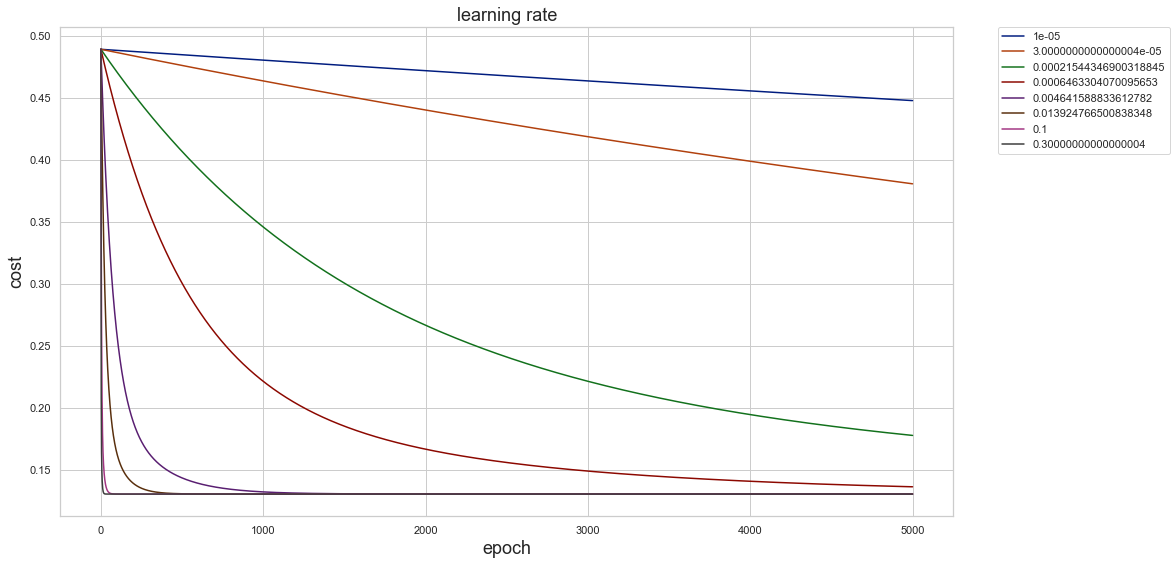

In [33]:
epoch=5000

fig, ax = plt.subplots(figsize=(16, 9))

for alpha in candidate:
    _, cost_data = batch_gradient_decent(theta, X, y, epoch, alpha=alpha)
    ax.plot(np.arange(epoch+1), cost_data, label=alpha)

ax.set_xlabel('epoch', fontsize=18)
ax.set_ylabel('cost', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('learning rate', fontsize=18)
plt.show()

# 4. normal equation（正规方程）
正规方程是通过求解下面的方程来找出使得代价函数最小的参数的：$\frac{\partial }{\partial {{\theta }_{j}}}J\left( {{\theta }_{j}} \right)=0$ 。
 假设我们的训练集特征矩阵为 X（包含了${{x}_{0}}=1$）并且我们的训练集结果为向量 y，则利用正规方程解出向量 $\theta ={{\left( {{X}^{T}}X \right)}^{-1}}{{X}^{T}}y$ 。
上标T代表矩阵转置，上标-1 代表矩阵的逆。设矩阵$A={{X}^{T}}X$，则：${{\left( {{X}^{T}}X \right)}^{-1}}={{A}^{-1}}$

梯度下降与正规方程的比较：

梯度下降：需要选择学习率α，需要多次迭代，当特征数量n大时也能较好适用，适用于各种类型的模型	

正规方程：不需要选择学习率α，一次计算得出，需要计算${{\left( {{X}^{T}}X \right)}^{-1}}$，如果特征数量n较大则运算代价大，因为矩阵逆的计算时间复杂度为O(n3)，通常来说当n小于10000 时还是可以接受的，只适用于线性模型，不适合逻辑回归模型等其他模型



In [34]:
# 正规方程
def normalEqn(X, y):
    theta = np.linalg.inv(X.T@X)@X.T@y#X.T@X等价于X.T.dot(X)
    return theta

In [35]:
final_theta2=normalEqn(X, y)#感觉和批量梯度下降的theta的值有点差距，这个怀疑是标注话以后导致的，需要在把模型训练出来的系数还原一下
final_theta2

array([-7.63278329e-17,  8.84765988e-01, -5.31788197e-02])

In [36]:
# 计算最终的代价
lr_cost(final_theta2, X, y)

0.13068648053904192

In [37]:
 0.13068648053904191597

0.13068648053904192

# run the tensorflow graph over several optimizer

In [38]:
X_data = get_X(data)
print(X_data.shape, type(X_data))

y_data = get_y(data).reshape(len(X_data), 1)  # special treatment for tensorflow input data
print(y_data.shape, type(y_data))

(47, 3) <class 'numpy.ndarray'>
(47, 1) <class 'numpy.ndarray'>


In [46]:
epoch = 2000
alpha = 0.01

In [47]:
optimizer_dict={'GD': tf.train.GradientDescentOptimizer,
                'Adagrad': tf.train.AdagradOptimizer,
                'Adam': tf.train.AdamOptimizer,
                'Ftrl': tf.train.FtrlOptimizer,
                'RMS': tf.train.RMSPropOptimizer
               }
results = []
for name in optimizer_dict:
    res = linear_regression(X_data, y_data, alpha, epoch, optimizer=optimizer_dict[name])
    res['name'] = name
    results.append(res)

# 画图

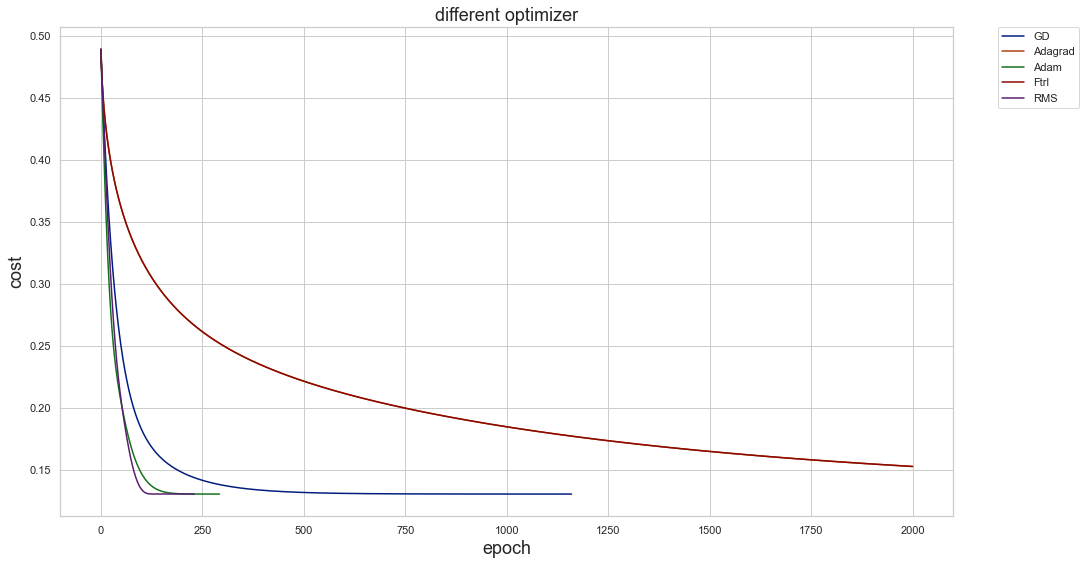

In [48]:
fig, ax = plt.subplots(figsize=(16, 9))

for res in results: 
    loss_data = res['loss']
    
#     print('for optimizer {}'.format(res['name']))
#     print('final parameters\n', res['parameters'])
#     print('final loss={}\n'.format(loss_data[-1]))
    ax.plot(np.arange(len(loss_data)), loss_data, label=res['name'])

ax.set_xlabel('epoch', fontsize=18)
ax.set_ylabel('cost', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('different optimizer', fontsize=18)
plt.show()

## 辅助联系

1.dataFrame的切片操作
2.

In [42]:
t = np.arange(0,25).reshape(5,5) ## 5行5列
tt = pd.DataFrame(t)
tt.insert(0,"b",8)
tt

tt.iloc[:,:-1] ## 所有行，第一列到倒数第二列

tt.iloc[:,-1] ## 所有行的最后一列

data

# PYTHON的切片结束位置不包含偏移数本身，所以：-1切片到的最后内容是倒数第二列的元素。
data.iloc[:, :-1].values


## ones 统一增加函数的偏置项b
ones = pd.DataFrame({'ones': np.ones(len(df))})#ones是m行1列的dataframe
data = pd.concat([ones, df], axis=1)  # 合并数据，根据列合并   1 左右方向合并   0 是上下方向合并